# Preliminaries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import math

%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# Cleaning the data

In [36]:
# Read the CSV files
df1 = pd.read_csv('game_info.csv')
df2 = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
df3 = pd.read_csv('games.csv')

# Standardizing the column names
df2.columns = df2.columns.str.lower()
df1.columns = df1.columns.str.lower()

# Drop rows where 'genres' is missing
df1 = df1.dropna(subset=['genres'])

# Standardize values with the same meaning
df2['genre']= df2['genre'].replace('Role-Playing', 'RPG')
df2['genre']= df2['genre'].replace('Platform', 'Platformer')

# This will only keep rows where the 'name' is found in both dataframes
merged_df = pd.merge(df2, df1, on='name', how='left', suffixes=('_df2', '_df1'))

# Update 'genre' column with 'genres' value if 'genres' is not empty
merged_df['genre'] = merged_df.apply(lambda row: row['genres'] if pd.notna(row['genres']) else row['genre'], axis=1)

columns_to_drop=['platform', 'critic_score',
       'critic_count', 'user_score', 'user_count', 'developer', 'rating_df2',
       'id', 'slug', 'metacritic', 'released', 'tba', 'updated', 'website',
       'rating_df1', 'rating_top', 'playtime', 'achievements_count',
       'ratings_count', 'suggestions_count', 'game_series_count',
       'reviews_count', 'platforms', 'developers', 'publishers', 'esrb_rating',
       'added_status_yet', 'added_status_owned', 'added_status_beaten',
       'added_status_toplay', 'added_status_dropped', 'added_status_playing', 'genres']
# Drop the redundant columns
genre_and_sales_df = merged_df.drop(columns=columns_to_drop)
genre_and_sales_df

,name,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,Wii Sports,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53
1,Super Mario Bros.,1985.0,Action||Adventure||Platformer,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52
3,Wii Sports Resort,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77
4,Pokemon Red/Pokemon Blue,1996.0,RPG,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...
16718,Samurai Warriors: Sanada Maru,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01
16719,LMA Manager 2007,2006.0,Strategy||Sports,Codemasters,0.00,0.01,0.00,0.00,0.01
16720,Haitaka no Psychedelica,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01
16721,Spirits & Spells,2003.0,Platformer,Wanadoo,0.01,0.00,0.00,0.00,0.01


Currently games which were released on multiple platforms have a separate row for each platform. We will aggregate the sales on all platforms together under each game.

In [37]:
aggregation_dict = {
    'name': 'first',
    'year_of_release': 'first',
    'publisher': 'first',
    'genre': 'first',
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'jp_sales': 'sum',
    'other_sales': 'sum',
    'global_sales': 'sum'
}
merged_sales = genre_and_sales_df.groupby('name', as_index=False).agg(aggregation_dict)

# Genre analysis

## Genre popularity globally

Now we will separate all of the genre values in the genre column.

In [38]:
# Get unique genre names
genre_series = merged_sales['genre'].str.split('\|\|', expand=True).stack()
unique_genres = genre_series.unique()

Create a new dataframe with only relevant info and plot the total number of global sales by genre.

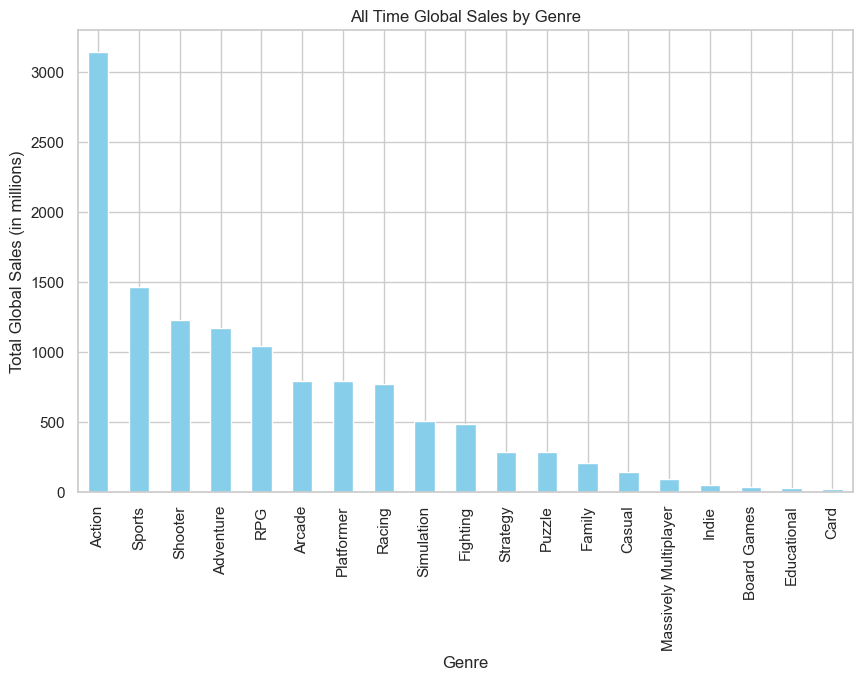

In [39]:
# Create a new DataFrame with name, release year, genre and sales 
genres_df = pd.DataFrame({
    'name': merged_sales['name'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'year_of_release': merged_sales['year_of_release'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'publisher': merged_sales['publisher'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'genre': genre_series.values,
    'na_sales': merged_sales['na_sales'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'eu_sales': merged_sales['eu_sales'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'jp_sales': merged_sales['jp_sales'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'other_sales': merged_sales['other_sales'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'global_sales': merged_sales['global_sales'].iloc[genre_series.index.get_level_values(0)].tolist()
})

# Remove 'Misc', because it is ambiguous and doesn't contribute anything meaningful to the analysis
genres_df = genres_df[genres_df['genre'] != 'Misc']

# Group by 'genre' and sum the global sales
total_sales_by_genre = genres_df.groupby('genre')['global_sales'].sum().sort_values(ascending=False)

# Plot bar chart
total_sales_by_genre.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('All Time Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Global Sales (in millions)')
plt.show()

We can see that action games have by far the highest sales. It is followed by sports, shooter, adventure and RPG. (Note that since games can have more than one genre, these columns do not add up to the total number of global sales.) To get further insight we need to also find the relative frequencies of genres. 

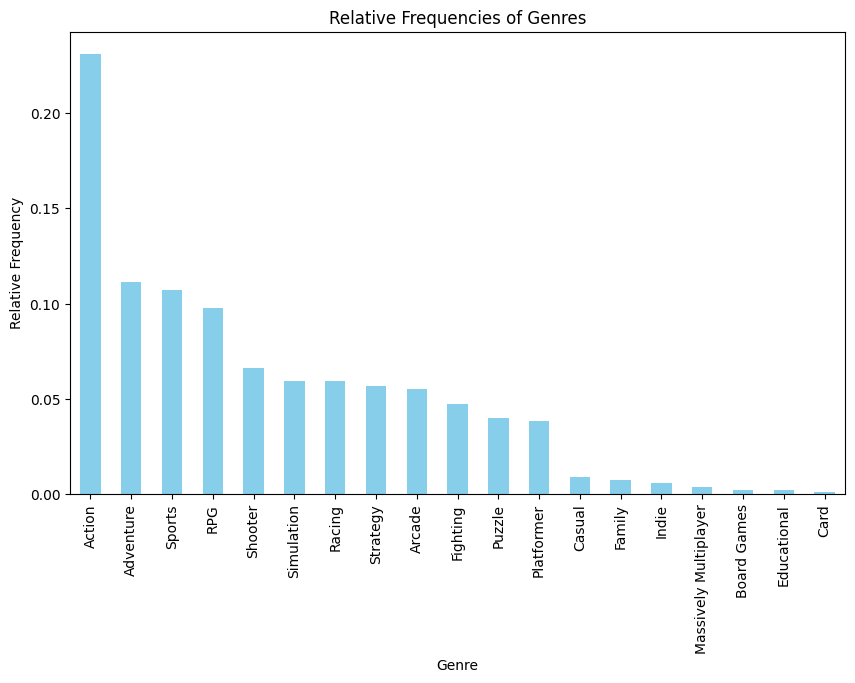

In [7]:
# Count the occurrences of each genre
genre_counts = genres_df['genre'].value_counts()
# Calculate relative frequencies (proportions)
relative_frequencies = (genre_counts / len(genres_df)).sort_values(ascending=False)

# Plot bar chart with relative frequencies
relative_frequencies.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Relative Frequencies of Genres')
plt.xlabel('Genre')
plt.ylabel('Relative Frequency')
plt.show()

We can see that 20% of the games in the dataset are listed under the action category and the top 5 games with highest sales also have the highest relative frequencies. This means that the high sales numbers could simply be because these types of games make up a significant percentage of the market, not because they are inherently more likely to have higher sales. <br>
To get more insight, we need to also look at the average sales. 

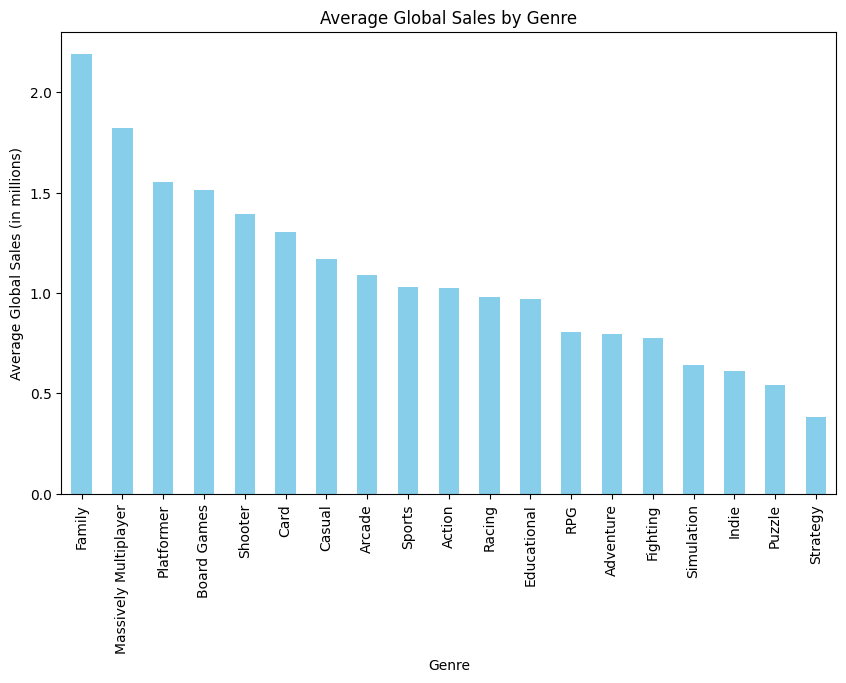

In [8]:
# Group by 'genre' and calculate the average global sales
average_sales_by_genre = genres_df.groupby('genre')['global_sales'].mean().sort_values(ascending=False)

# Plot bar chart with average global sales
average_sales_by_genre.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Average Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Global Sales (in millions)')
plt.show()

As we can see, four genres fell out of the TOP5. The only genre to retain its spot was the shooter genre. <br>
Family, massively multiplayer (MMO), platformer and board games seem to have the highest average sales. 

The averages could be skewed due to low sample sizes and significant ouliers, so we can also find the median global sales. 

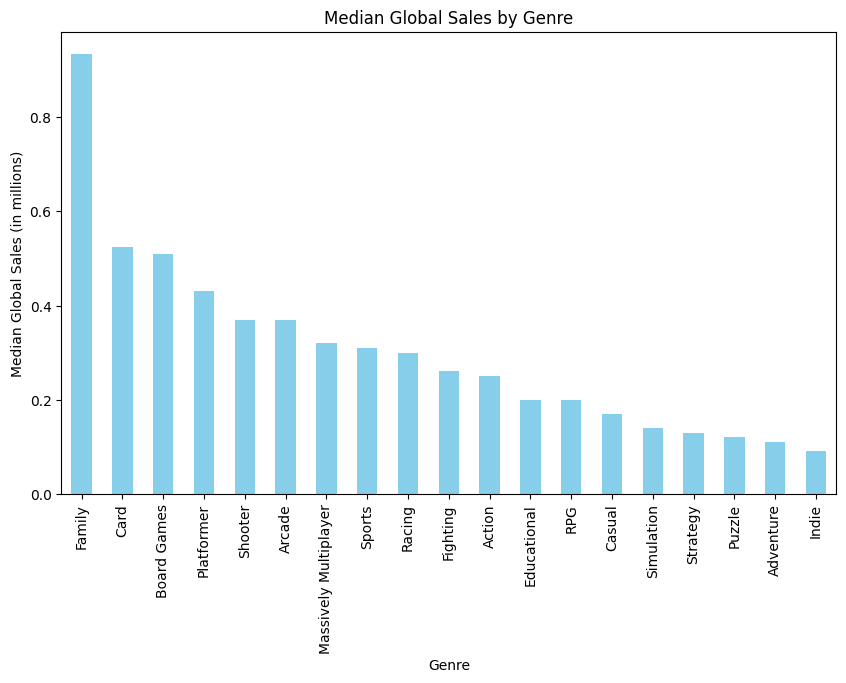

In [8]:
# Group by 'genre' and calculate the average global sales
average_sales_by_genre = genres_df.groupby('genre')['global_sales'].median().sort_values(ascending=False)

# Plot bar chart with average global sales
average_sales_by_genre.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Median Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Median Global Sales (in millions)')
plt.show()

We can see that family games also have the highest median sales. Board games and platformers remained in the TOP5. Shooter games 
were pushed out by a very small margin. 

What we can take away from this is that family games on average have the highest sales. They also have a low relative frequency, which could indicate an untapped market. Platformers and board games indicate a similar trend. <br> 
The most consistenly high ranking in all metrics is the shooter genre. Shooters have high average sales despite the high amount of competition due to the high relative frequency. 

## Genre popularity by region

C:\Users\henri\AppData\Local\Temp\ipykernel_6600\160168834.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')


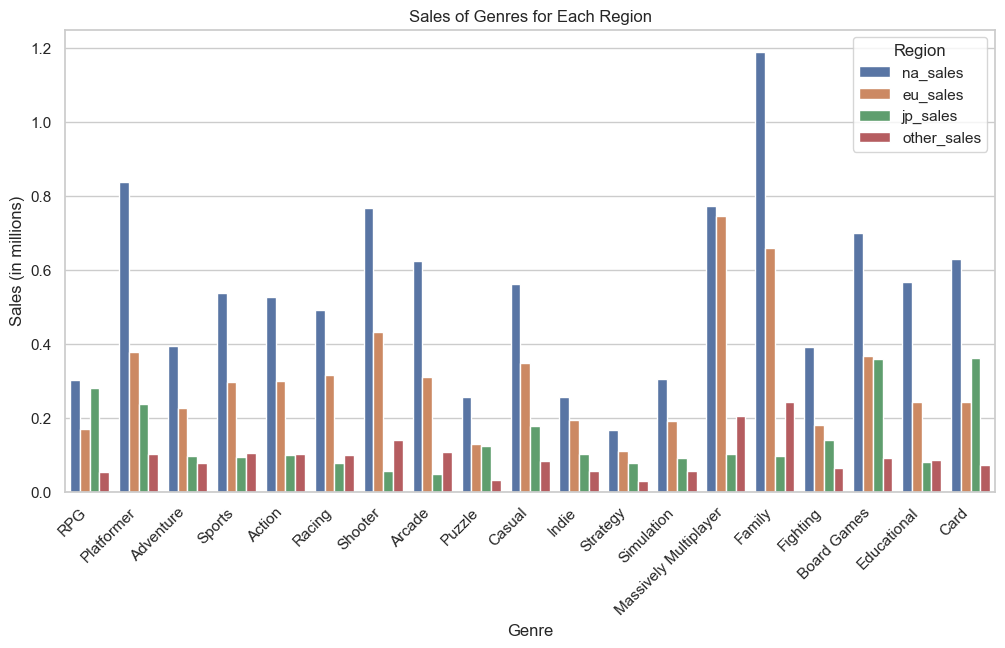

In [46]:

# Melt the DataFrame to reshape it for seaborn bar plot
melted_df = pd.melt(genres_df, id_vars=['genre'], value_vars=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                    var_name='region', value_name='sales')

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='genre', y='sales', hue='region', data=melted_df, errorbar=None)
bar_plot.set(title='Sales of Genres for Each Region', xlabel='Genre', ylabel='Sales (in millions)')
bar_plot.legend(title='Region', loc='upper right')

# Rotate x-axis labels for better readability
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
#plt.savefig('Sales of genres per region.svg', dpi=600, bbox_inches='tight')
plt.show()

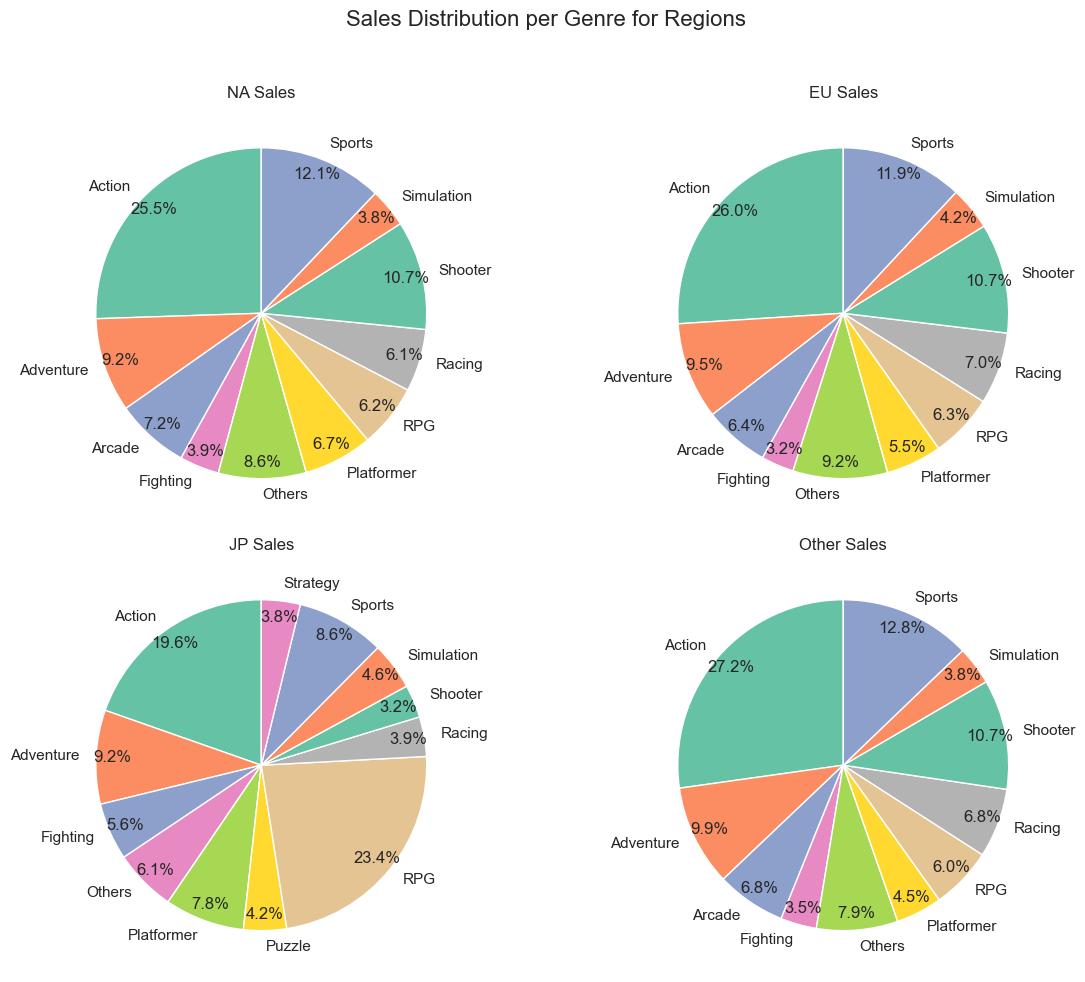

In [10]:
threshold = 3

def chartable_data(column):
    # Identify genres with 'na_sales' percentages smaller than the threshold
    sales_percentages = genres_df.groupby('genre')[column].sum() / genres_df[column].sum() * 100
    small_genres = sales_percentages[sales_percentages < threshold].index

    # Replace small genres with 'Others' in 'na_sales' percentages
    sales_df = genres_df.copy()
    sales_df['genre'] = sales_df['genre'].apply(lambda x: 'Others' if x in small_genres else x)

    # Group the data by genre and calculate the 'na_sales' percentages for each genre
    sales_data = sales_df.groupby('genre')[column].sum()
    return sales_data    

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Sales Distribution per Genre for Regions', fontsize=16)

sns.set(style="whitegrid")
color_palette = sns.color_palette("Set2")

# Pie chart for NA sales
na_sales_data = chartable_data('na_sales')
axes[0, 0].pie(na_sales_data, labels=na_sales_data.index, autopct='%1.1f%%', startangle=90, pctdistance=0.9, colors=color_palette)
axes[0, 0].set_title('NA Sales')

# Pie chart for EU sales
eu_sales_data = chartable_data('eu_sales')
axes[0, 1].pie(eu_sales_data, labels=eu_sales_data.index, autopct='%1.1f%%', startangle=90, pctdistance=0.9, colors=color_palette)
axes[0, 1].set_title('EU Sales')

# Pie chart for JP sales
jp_sales_data = chartable_data('jp_sales')
axes[1, 0].pie(jp_sales_data, labels=jp_sales_data.index, autopct='%1.1f%%', startangle=90, pctdistance=0.9, colors=color_palette)
axes[1, 0].set_title('JP Sales')

# Pie chart for Other sales
other_sales_data = chartable_data('other_sales')
axes[1, 1].pie(other_sales_data, labels=other_sales_data.index, autopct='%1.1f%%', startangle=90, pctdistance=0.9, colors=color_palette)
axes[1, 1].set_title('Other Sales')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

There are insignificant differences in genre preference around the world. In Japan specifically, however, there is a much higher interest in RPGs and platformers. Conversely, there is a lower interest in action games, sports games and shooters. 

## Genre popularity over time globally

The following is plots for average and total sales in all regions by genre over time. 

In [11]:
def plot_mean_by_genre_per_year(column):
    # Group by 'genre' and 'year_of_release' and calculate the average global sales
    average_sales_by_genre_year = genres_df.groupby(['genre', 'year_of_release'])[column].mean().reset_index()

    # Get unique genres for subplot creation
    unique_genres = genres_df['genre'].unique()

    # Calculate the number of rows and columns needed for the grid
    num_plots = len(unique_genres)
    num_cols = 3  # Set the number of columns per row
    num_rows = math.ceil(num_plots / num_cols)

    # Create subplots for each genre in a grid layout
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 3 * num_rows))

    # Iterate through genres and plot average global sales for each year using scatter plot
    for i, genre in enumerate(unique_genres):
        genre_data = average_sales_by_genre_year[average_sales_by_genre_year['genre'] == genre]
        ax = axes[i // num_cols, i % num_cols]  # Calculate the current subplot position
        ax.scatter(genre_data['year_of_release'], genre_data[column], color='skyblue')
        ax.set_title(f'{genre}')
        ax.set_xlabel('Year')
        ax.set_ylabel(f'Average {column} (in millions)')
        ax.set_xlim(1980, 2020)
        ax.set_ylim(0, 16)

    # Remove any empty subplots
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

In [12]:
def plot_median_by_genre_per_year(column):
    # Group by 'genre' and 'year_of_release' and calculate the average global sales
    average_sales_by_genre_year = genres_df.groupby(['genre', 'year_of_release'])[column].median().reset_index()

    # Get unique genres for subplot creation
    unique_genres = genres_df['genre'].unique()

    # Calculate the number of rows and columns needed for the grid
    num_plots = len(unique_genres)
    num_cols = 3  # Set the number of columns per row
    num_rows = math.ceil(num_plots / num_cols)

    # Create subplots for each genre in a grid layout
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 3 * num_rows))

    # Iterate through genres and plot average global sales for each year using scatter plot
    for i, genre in enumerate(unique_genres):
        genre_data = average_sales_by_genre_year[average_sales_by_genre_year['genre'] == genre]
        ax = axes[i // num_cols, i % num_cols]  # Calculate the current subplot position
        ax.scatter(genre_data['year_of_release'], genre_data[column], color='skyblue')
        ax.set_title(f'{genre}')
        ax.set_xlabel('Year')
        ax.set_ylabel(f'Average {column} (in millions)')
        ax.set_xlim(1980, 2020)
        ax.set_ylim(0, 16)

    # Remove any empty subplots
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

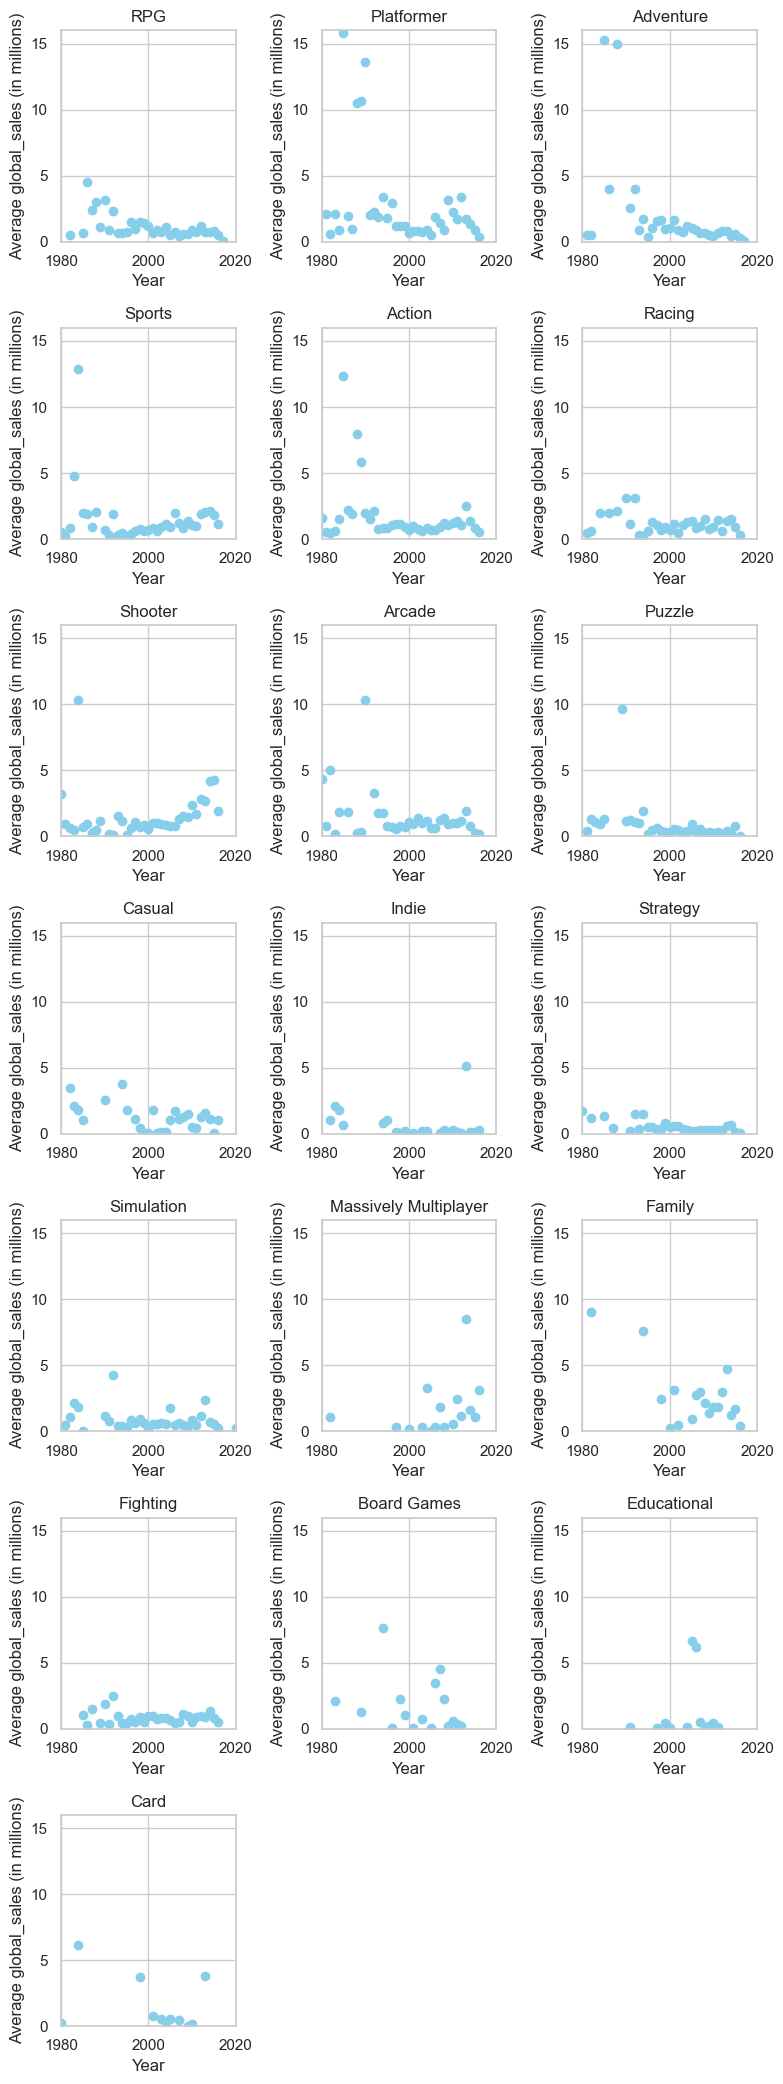

In [13]:
plot_mean_by_genre_per_year('global_sales')

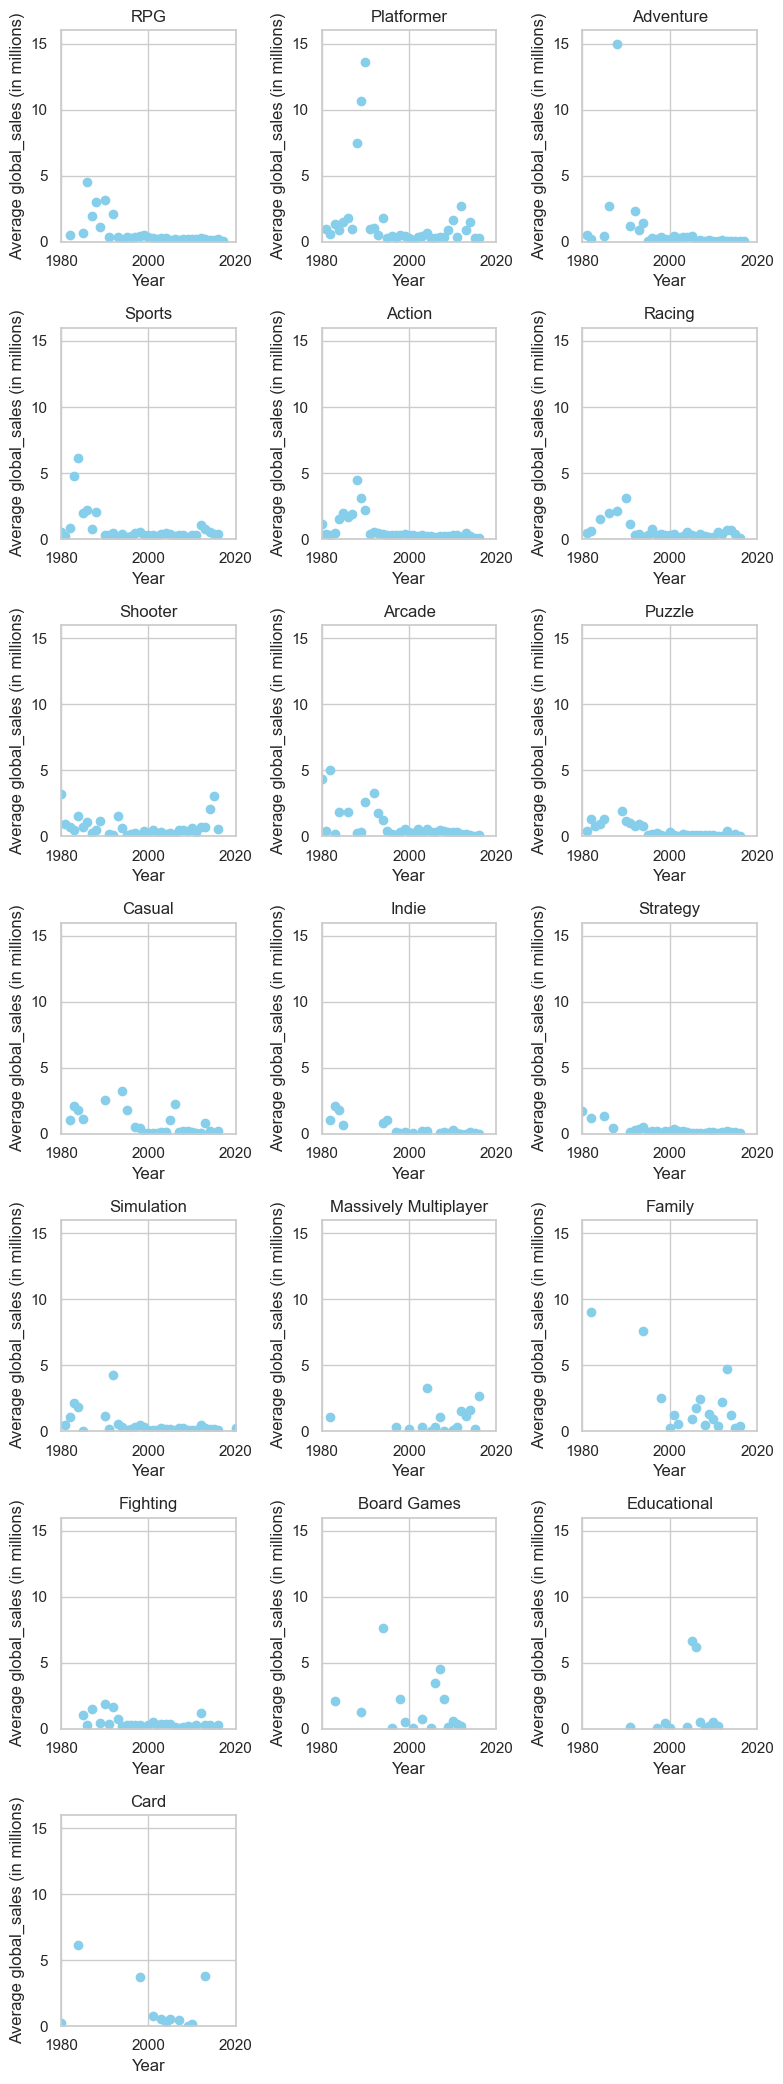

In [14]:
plot_median_by_genre_per_year('global_sales')

The graphs of the means and medians are virtually identical, which means that there aren't any significant outliers. The graphs indicate that games in the 80s and 90s had more sales on average. 

In [15]:
genres_df['decade'] = (genres_df['year_of_release'] // 10) * 10

# Count the number of entries for each decade
decade_counts = genres_df['decade'].value_counts().sort_index()

# Print the results
print("Number of Entries for Each Decade:")
print(decade_counts)
genres_df = genres_df.drop(columns=['decade'])

Number of Entries for Each Decade:
decade
1980.0     248
1990.0    1884
2000.0    7140
2010.0    3814
2020.0       1
Name: count, dtype: int64


As we can see, there are significantly fewer entries from the 80s and 90s. So the reason that the 20th century had such large average sales numbers, is because there were fewer games to buy, hence increasing the average sales. In the 2000s the market has increased significantly and consists of few big titles with very large earnings and many smaller titles with smaller earnings. 

In [16]:
def plot_total_by_genre_per_year(column):
    # Group by 'genre' and 'year_of_release' and calculate the average global sales
    total_sales_by_genre_year = genres_df.groupby(['genre', 'year_of_release'])[column].sum().reset_index()

    # Get unique genres for subplot creation
    unique_genres = genres_df['genre'].unique()

    # Calculate the number of rows and columns needed for the grid
    num_plots = len(unique_genres)
    num_cols = 3  # Set the number of columns per row
    num_rows = math.ceil(num_plots / num_cols)

    # Create subplots for each genre in a grid layout
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 3 * num_rows))

    # Iterate through genres and plot average global sales for each year using scatter plot
    for i, genre in enumerate(unique_genres):
        genre_data = total_sales_by_genre_year[total_sales_by_genre_year['genre'] == genre]
        ax = axes[i // num_cols, i % num_cols]  # Calculate the current subplot position
        ax.scatter(genre_data['year_of_release'], genre_data[column], color='skyblue')
        ax.set_title(f'{genre}')
        ax.set_xlabel('Year')
        ax.set_ylabel(f'Total {column} (in millions)')
        ax.set_xlim(1980, 2020)
        ax.set_ylim(0, 300)

    # Remove any empty subplots
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

In the following graphs you can see the increase in the sales of the most successful games of each year.

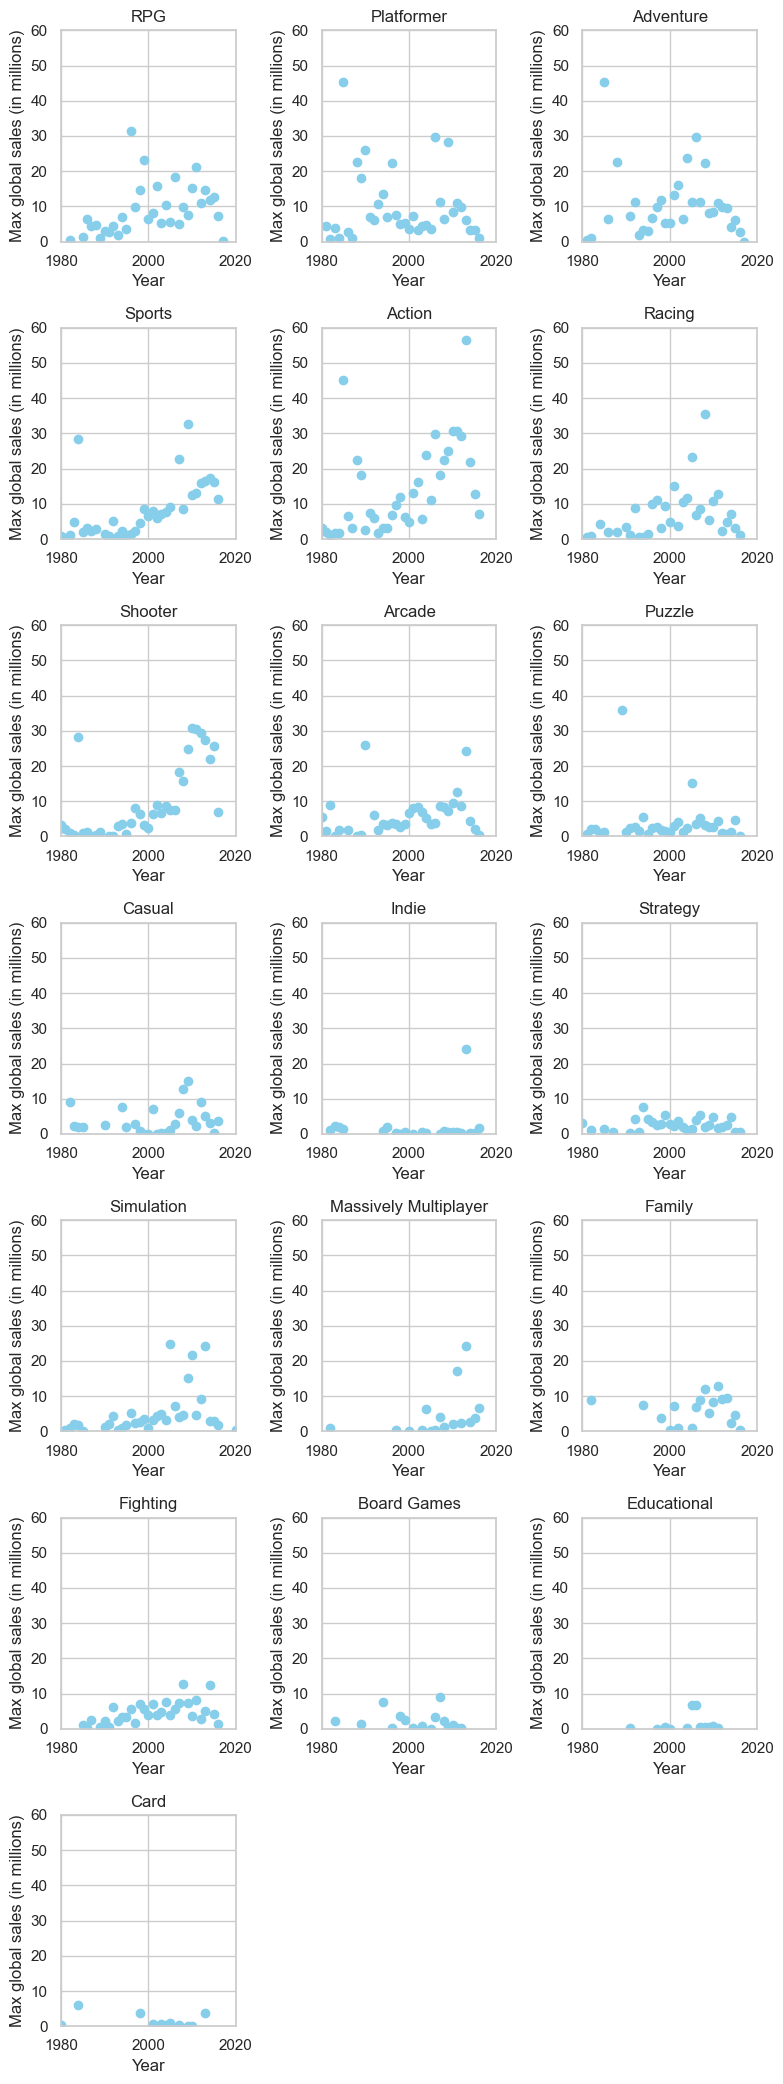

In [17]:
# Group by 'genre' and 'year_of_release' and calculate the average global sales
average_sales_by_genre_year = genres_df.groupby(['genre', 'year_of_release'])['global_sales'].max().reset_index()

# Get unique genres for subplot creation
unique_genres = genres_df['genre'].unique()

# Calculate the number of rows and columns needed for the grid
num_plots = len(unique_genres)
num_cols = 3  # Set the number of columns per row
num_rows = math.ceil(num_plots / num_cols)

# Create subplots for each genre in a grid layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 3 * num_rows))

# Iterate through genres and plot average global sales for each year using scatter plot
for i, genre in enumerate(unique_genres):
    genre_data = average_sales_by_genre_year[average_sales_by_genre_year['genre'] == genre]
    ax = axes[i // num_cols, i % num_cols]  # Calculate the current subplot position
    ax.scatter(genre_data['year_of_release'], genre_data['global_sales'], color='skyblue')
    ax.set_title(f'{genre}')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Max global sales (in millions)')
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 60)

# Remove any empty subplots
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In the following graph you can see the increase of total video game sales volume per year. 

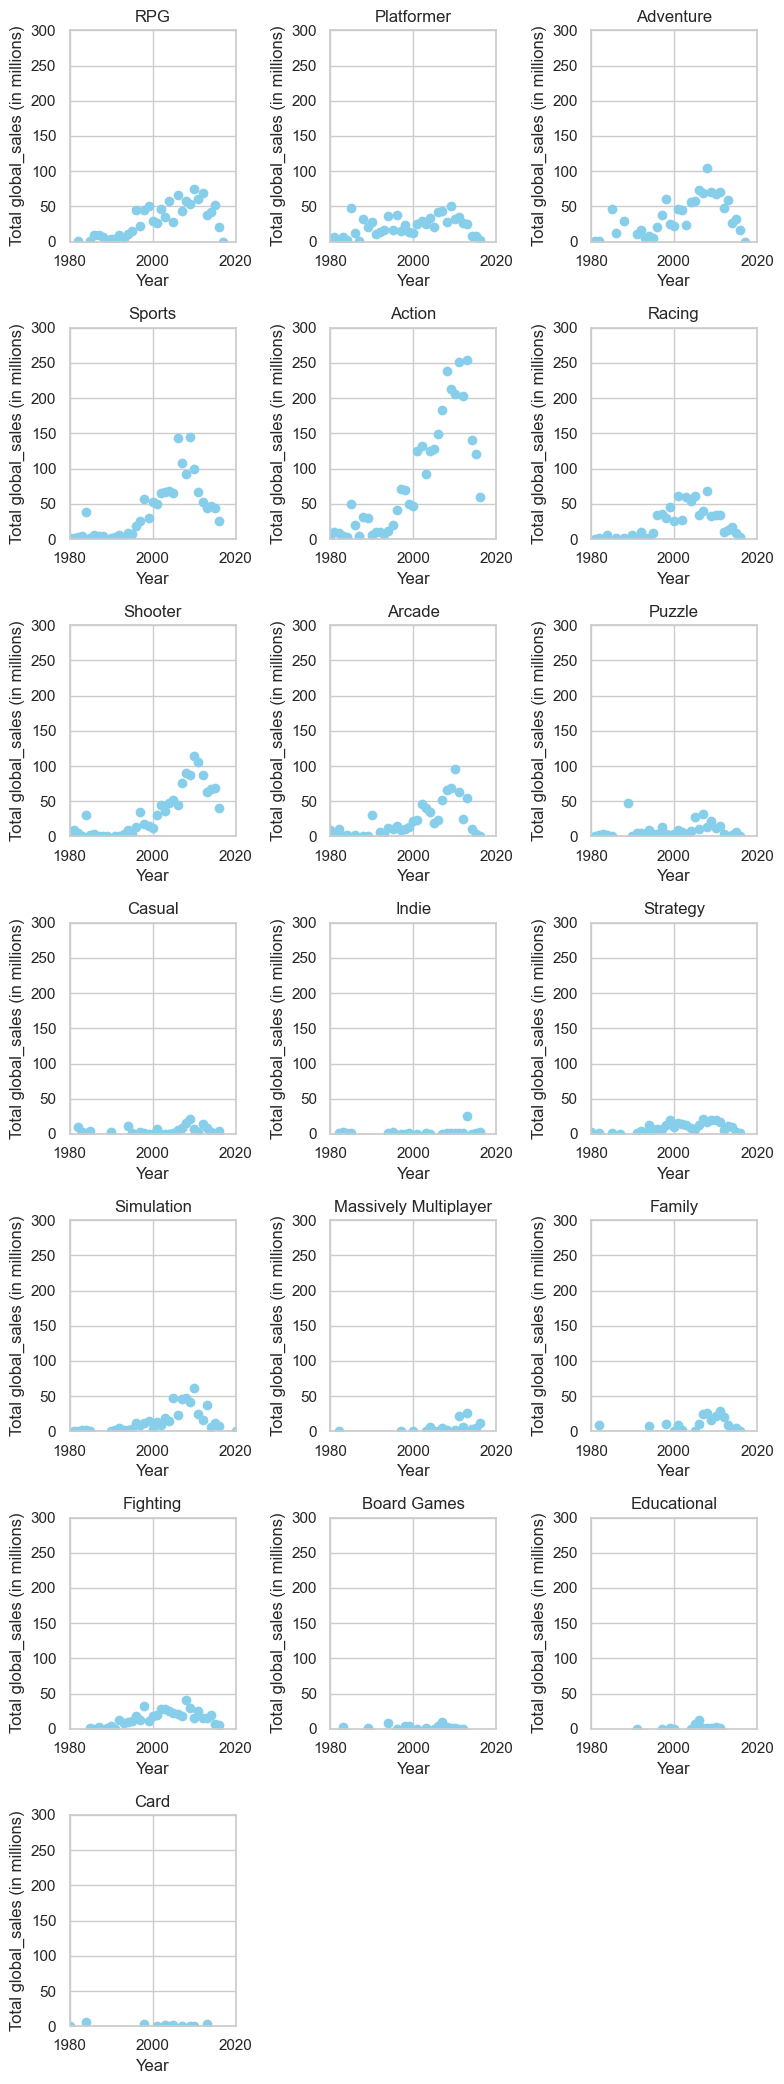

In [18]:
plot_total_by_genre_per_year('global_sales')

## Genre distribution analysis

To further indicate this, here are the distributions of video game sales in the last 4 decades. 

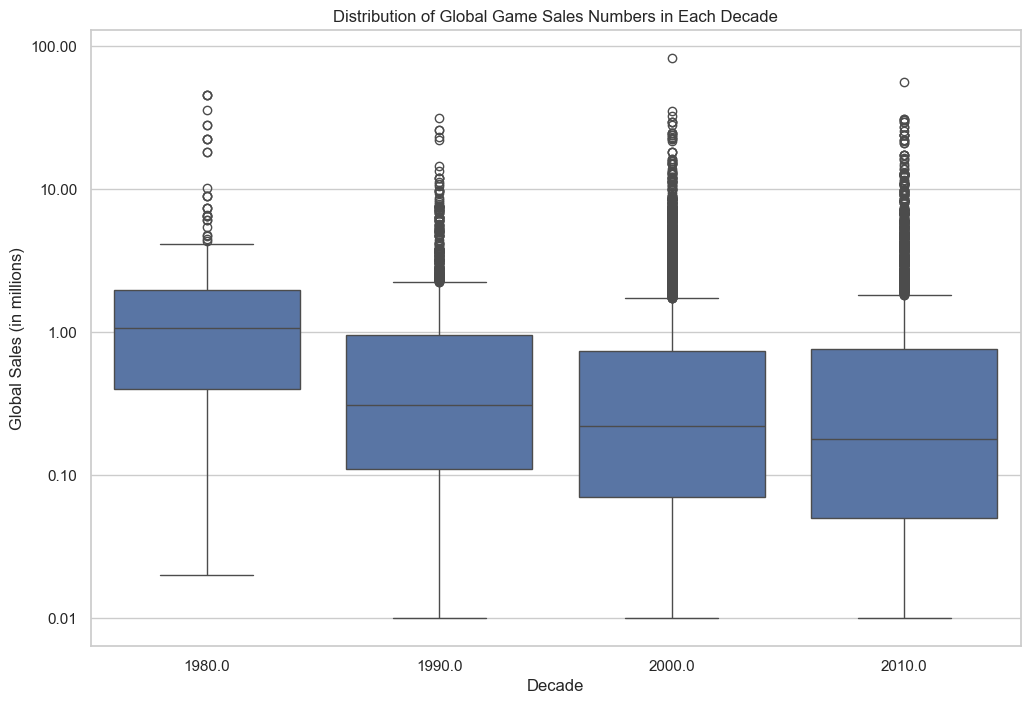

In [15]:
from matplotlib.ticker import FuncFormatter

def plot_distribution_per_decade(column):
    genres_df['decade'] = (genres_df['year_of_release'] // 10) * 10

    # 2020 only has one entry and 2010s data ends with 2016, making it disproportionate
    filtered_genres_df = genres_df[(genres_df['decade'] != 2020)]

    # Create a boxplot or violin plot for each decade
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")

    # Choose between boxplot or violinplot
    sns.boxplot(x='decade', y=column, data=filtered_genres_df)
    #sns.violinplot(x='decade', y='global_sales', data=filtered_genres_df)

    # Set logarithmic scale for the y-axis
    plt.yscale('log')

    # Format y-axis labels to display decimal numbers with two decimal places
    formatter = FuncFormatter(lambda x, _: '{:.2f}'.format(x))
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.title('Distribution of Global Game Sales Numbers in Each Decade')
    plt.xlabel('Decade')
    plt.ylabel('Global Sales (in millions)')
    #plt.show()
    plt.savefig('Distributions_by_decade.pdf')

plot_distribution_per_decade('global_sales')

As seen from the plot, game sales follow a normal distribution. As we can see, over time the volume of low earning games increases and the "tail" of high earning games gets longer. (Note the logarithmic scale!)

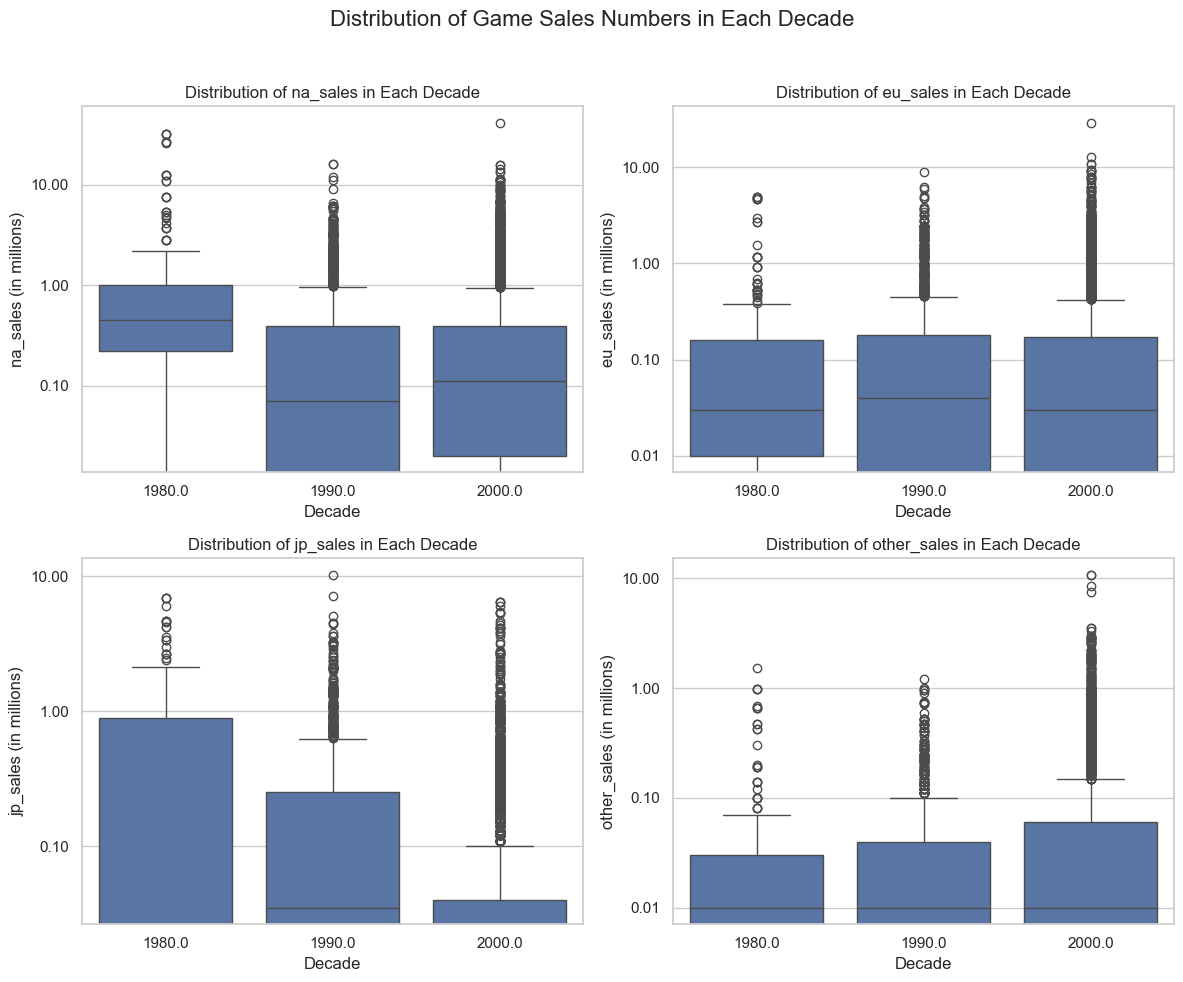

In [20]:
def plot_distribution_per_decade(ax, column):
    genres_df['decade'] = (genres_df['year_of_release'] // 10) * 10

    # Filter out decades 2010 and 2020
    filtered_genres_df = genres_df[(genres_df['decade'] != 2020) & (genres_df['decade'] != 2010)]

    # Create a boxplot for each decade
    sns.boxplot(x='decade', y=column, data=filtered_genres_df, ax=ax)
    #sns.violinplot(x='decade', y=column, data=filtered_genres_df, ax=ax)
    
    # Set logarithmic scale for the y-axis
    ax.set_yscale('log')

    # Format y-axis labels to display decimal numbers with two decimal places
    formatter = FuncFormatter(lambda x, _: '{:.2f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)

    ax.set_title(f'Distribution of {column} in Each Decade')
    ax.set_xlabel('Decade')
    ax.set_ylabel(f'{column} (in millions)')

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Distribution of Game Sales Numbers in Each Decade', fontsize=16)

# Specify columns for each subplot
columns = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

# Plot each column in a separate subplot
for ax, column in zip(axes.flatten(), columns):
    plot_distribution_per_decade(ax, column)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

## Additional metrics for genre popularity over time in every region

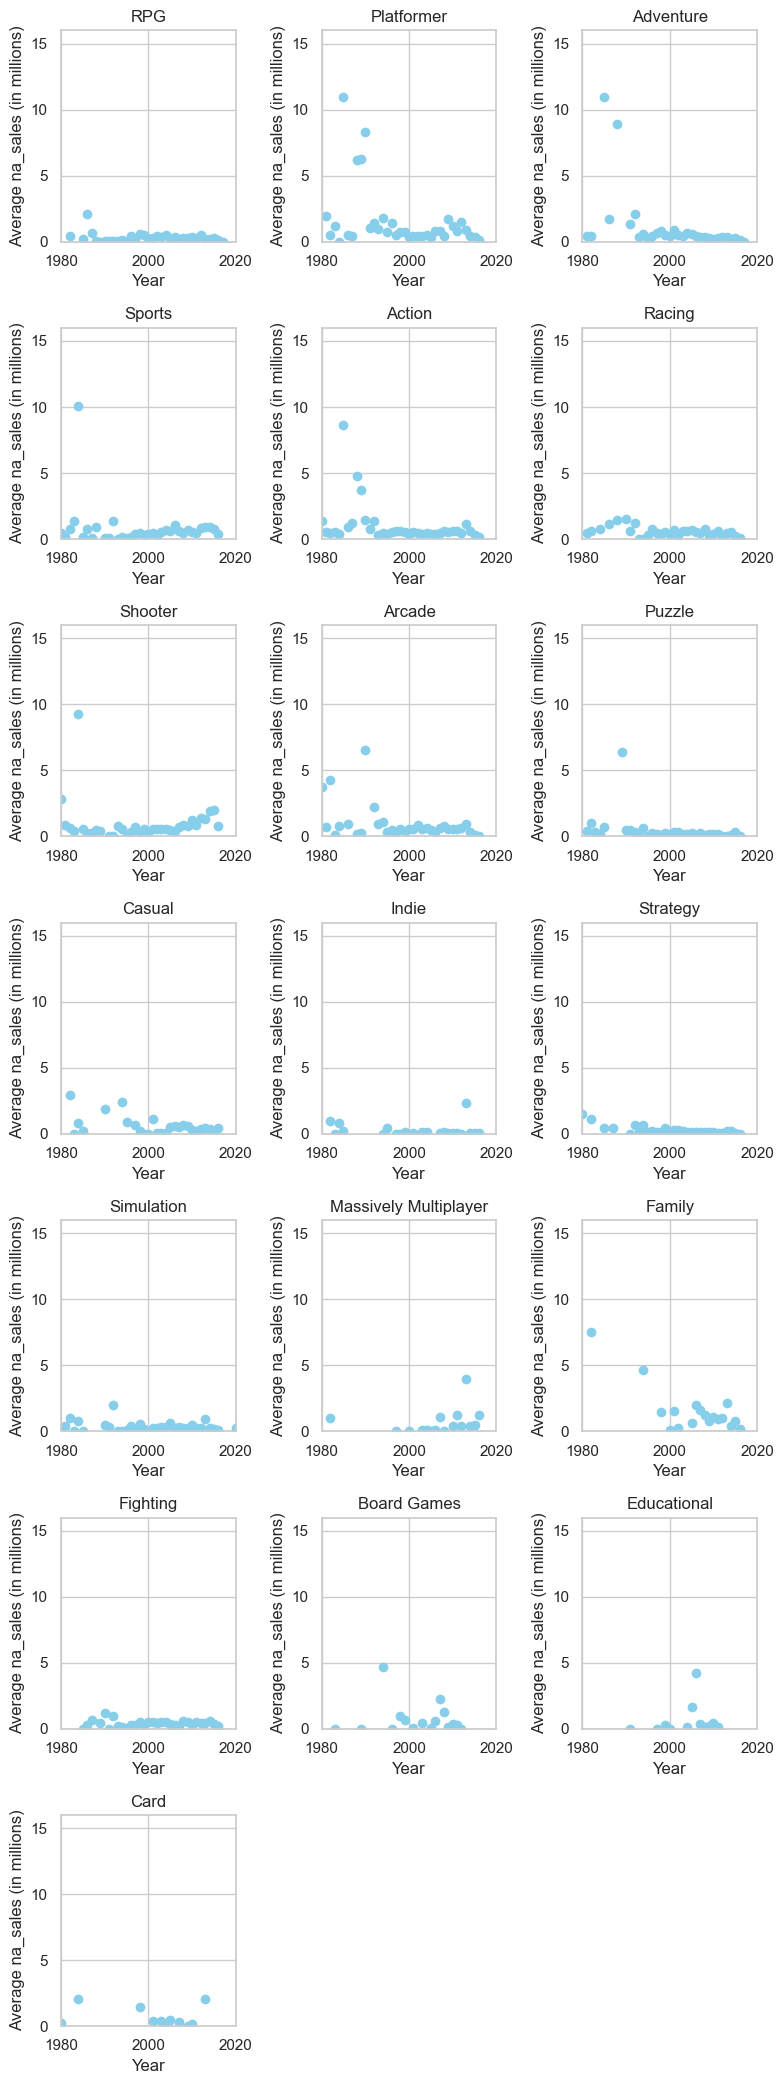

In [21]:
plot_mean_by_genre_per_year('na_sales')

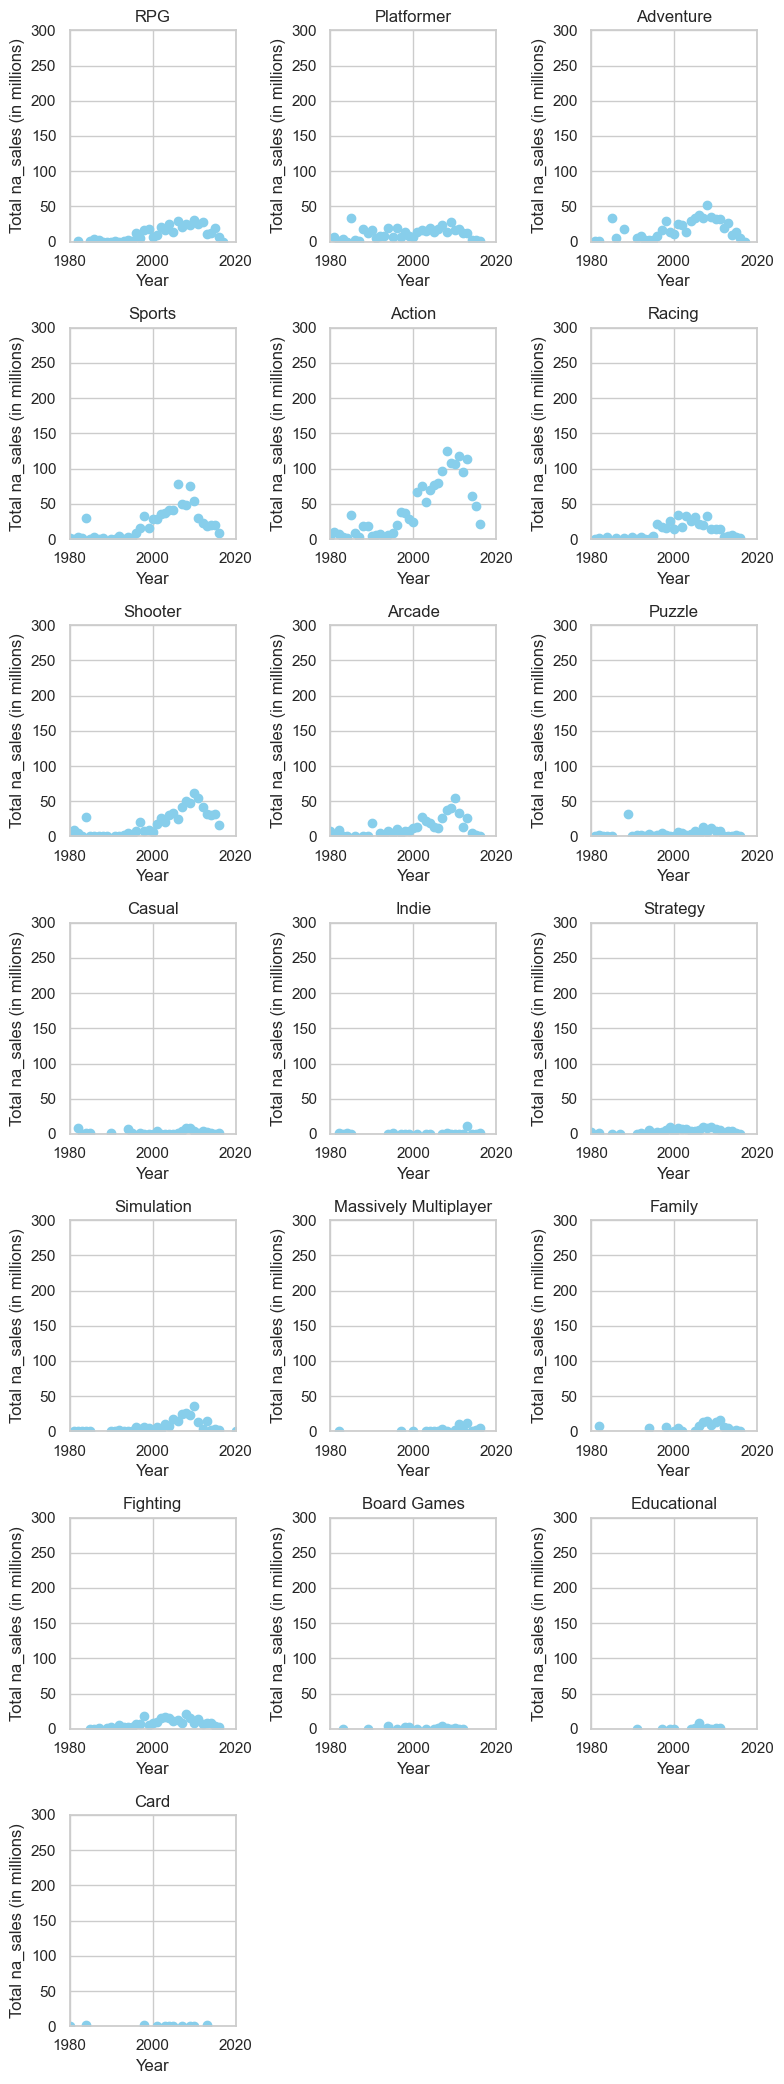

In [22]:
plot_total_by_genre_per_year('na_sales')

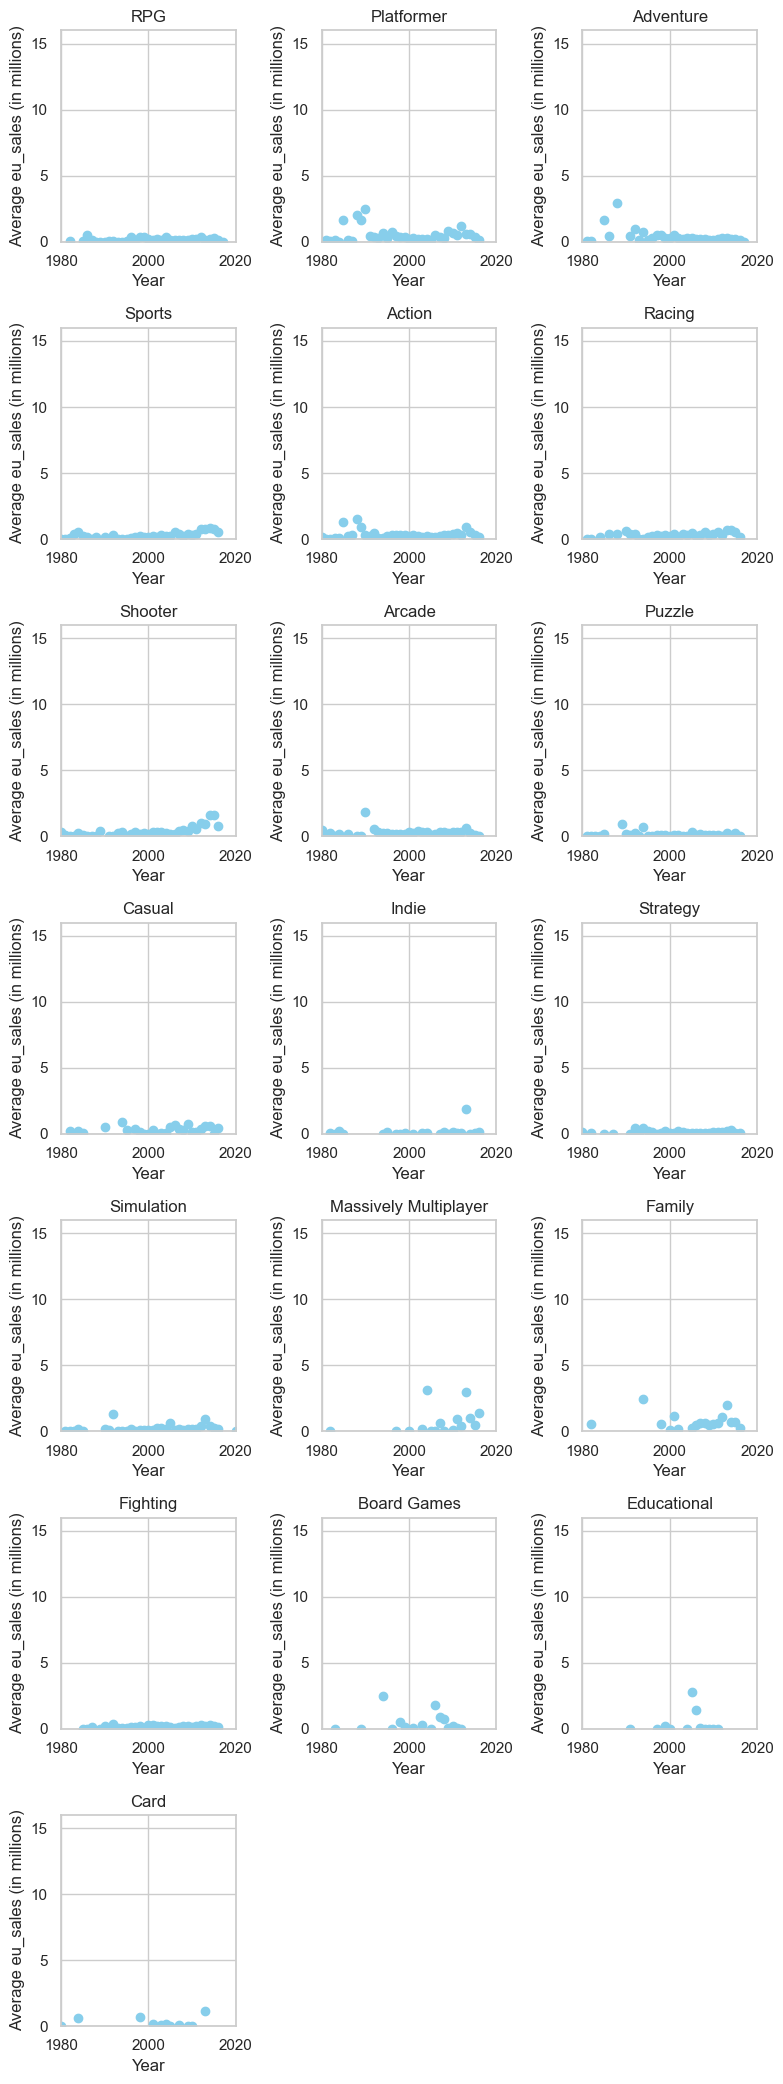

In [23]:
plot_mean_by_genre_per_year('eu_sales')

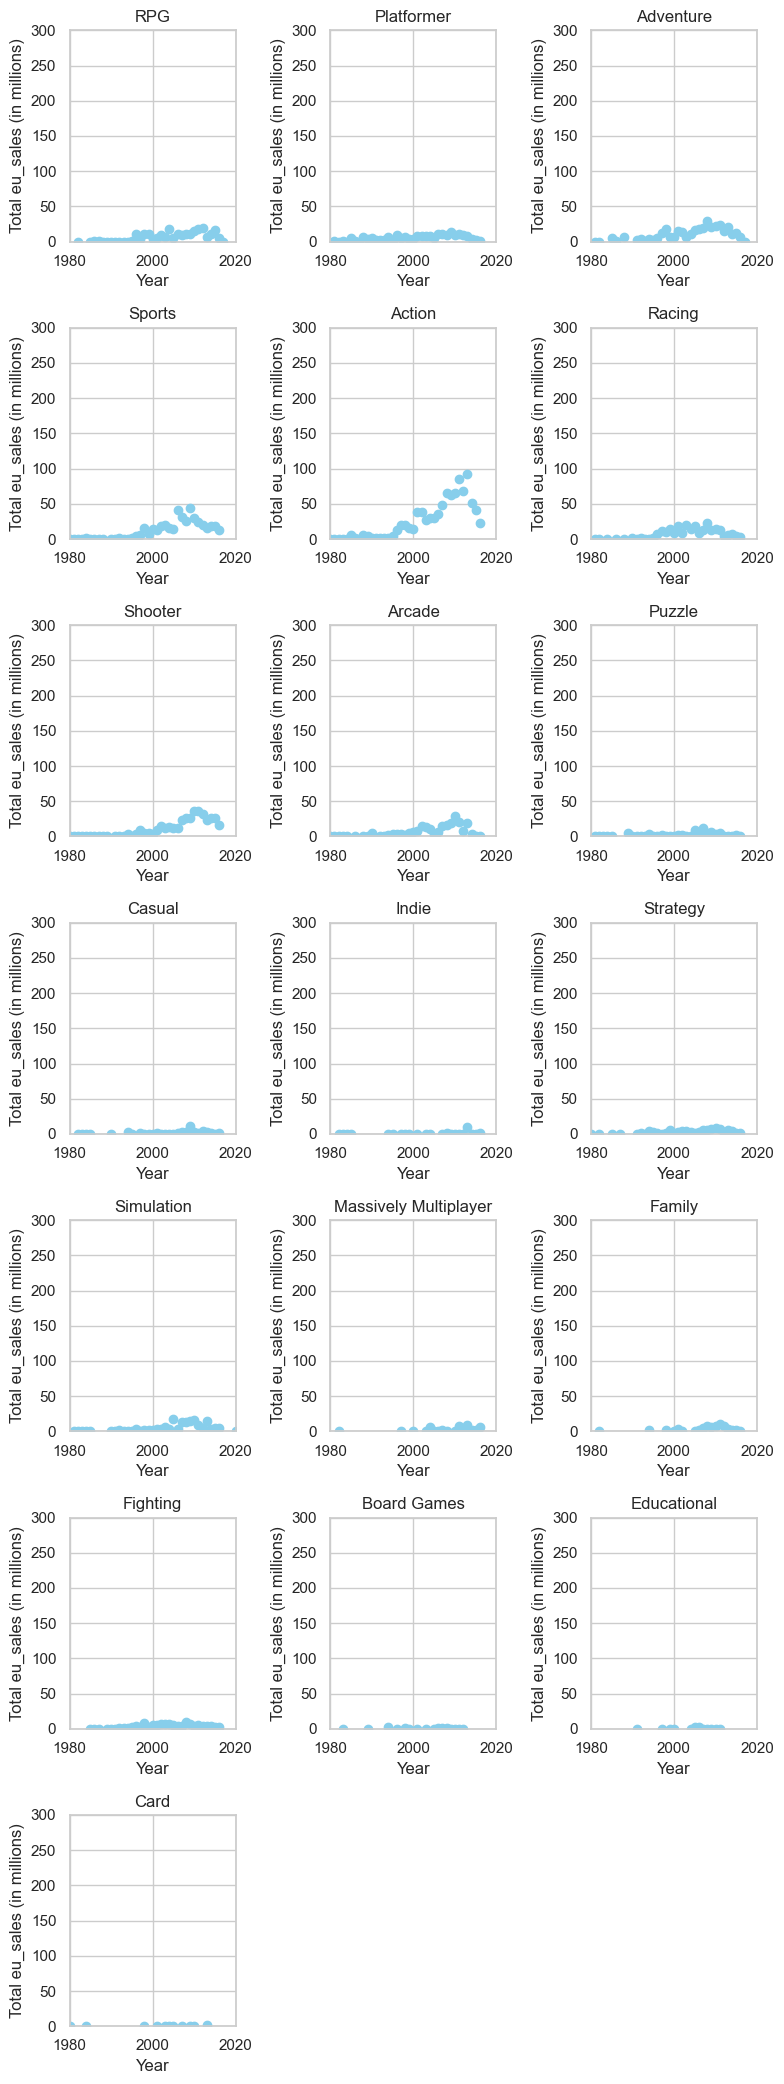

In [24]:
plot_total_by_genre_per_year('eu_sales')

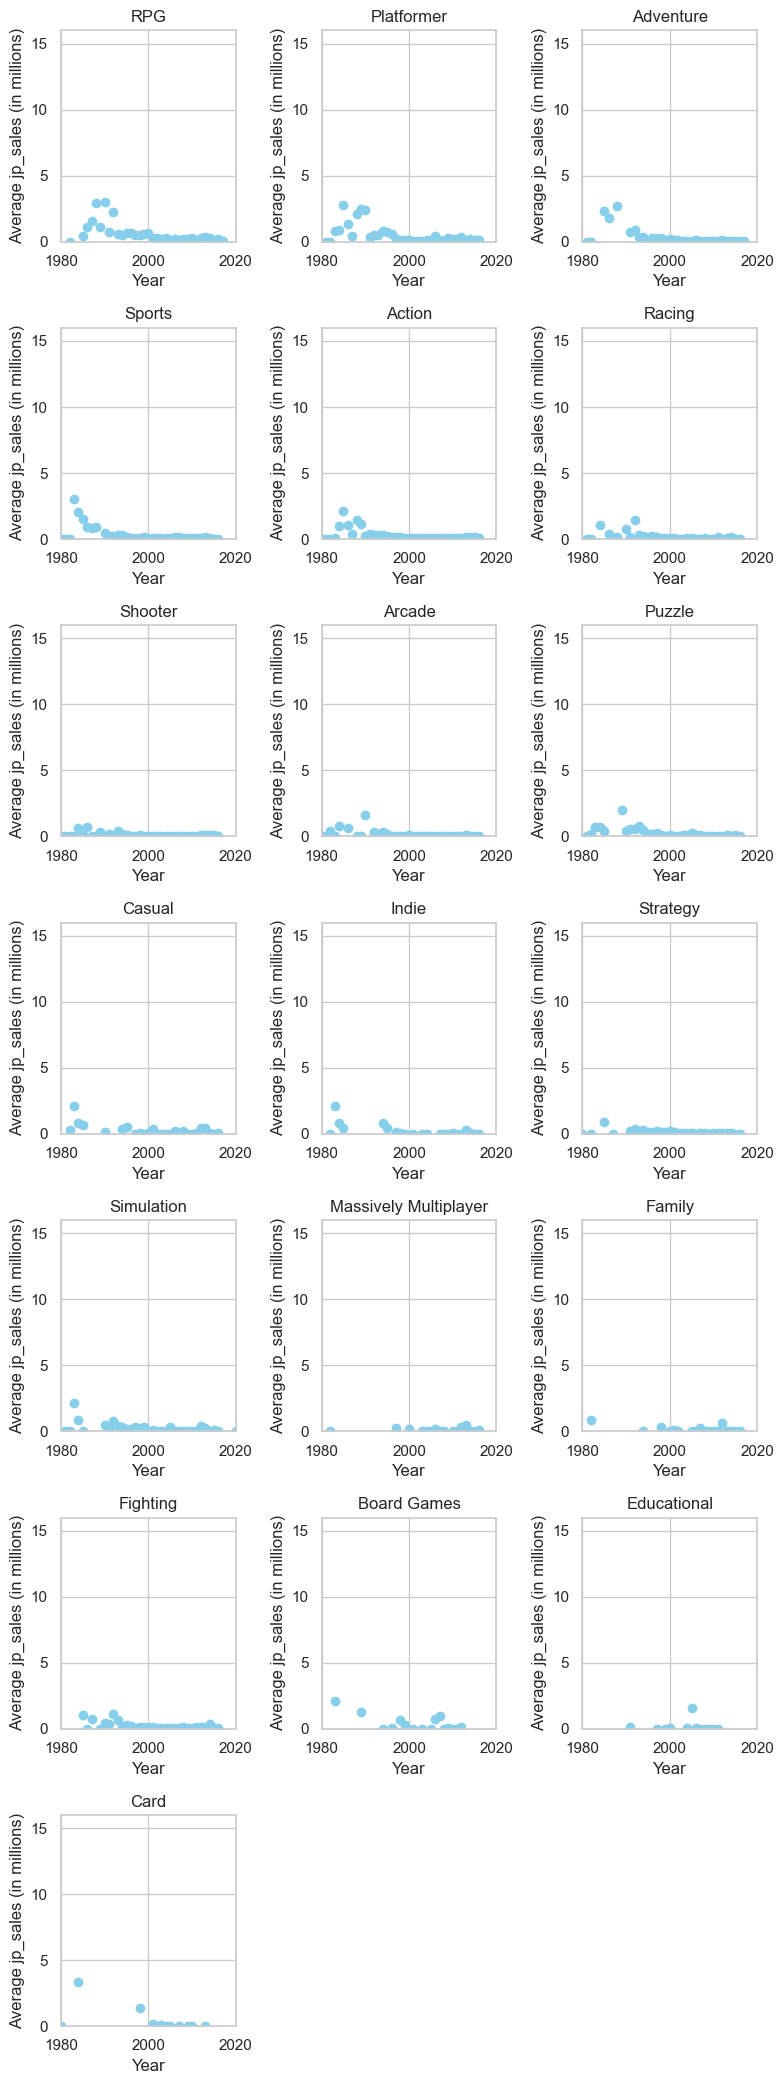

In [25]:
plot_mean_by_genre_per_year('jp_sales')

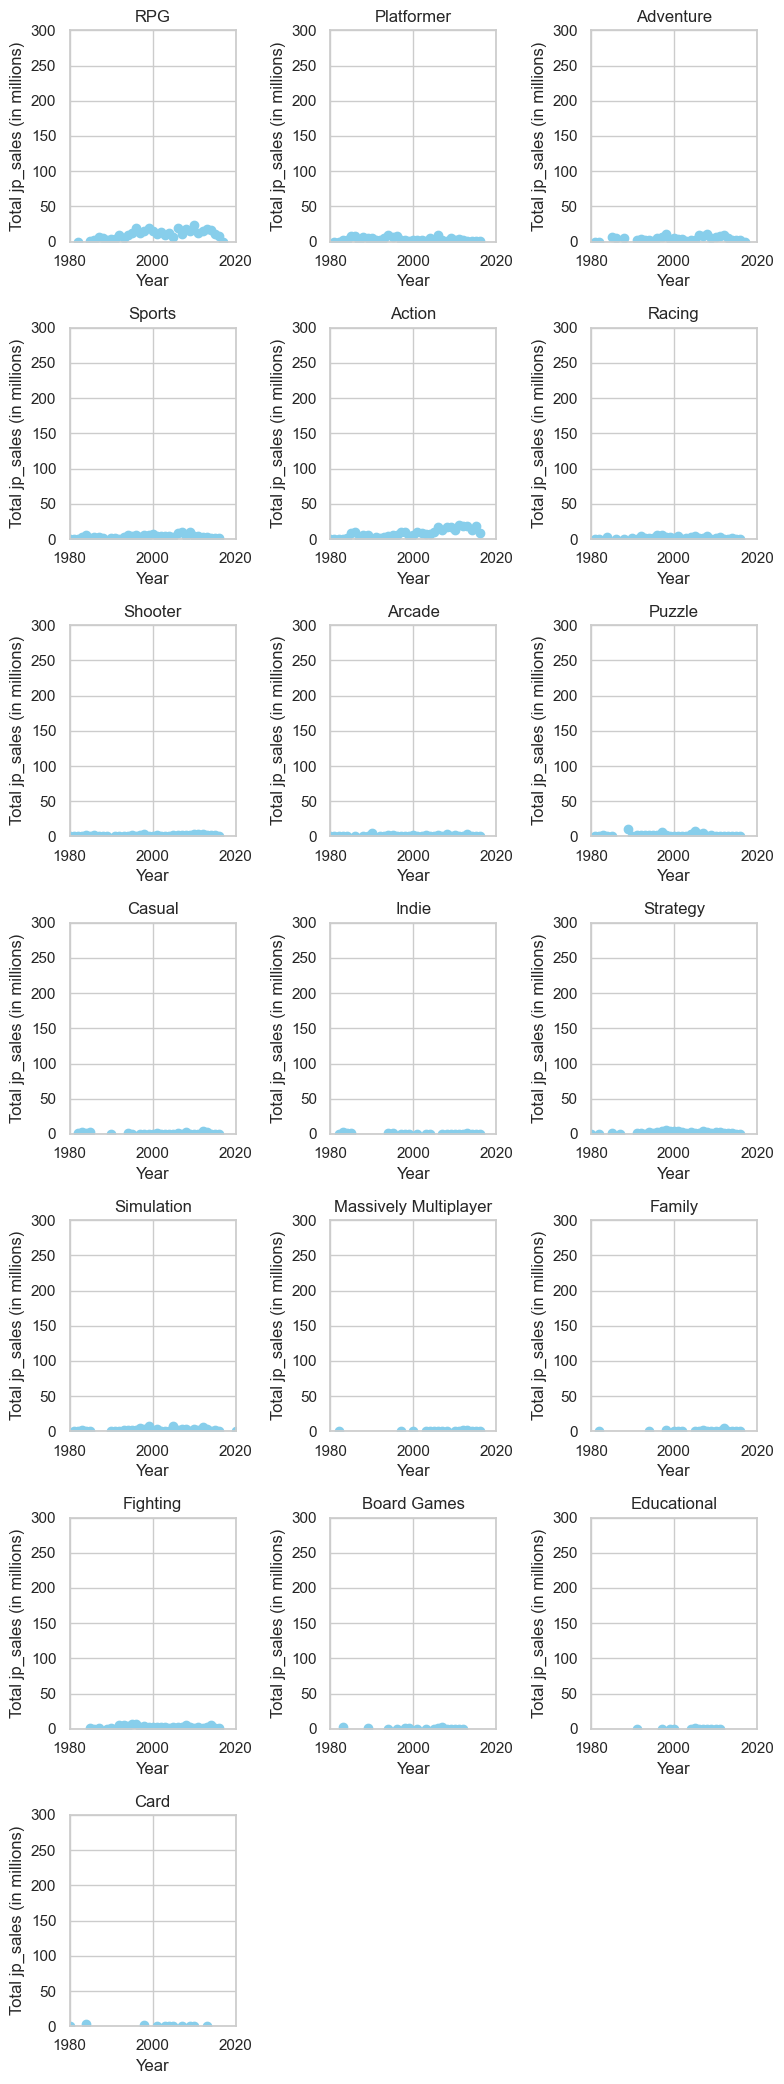

In [26]:
plot_total_by_genre_per_year('jp_sales')

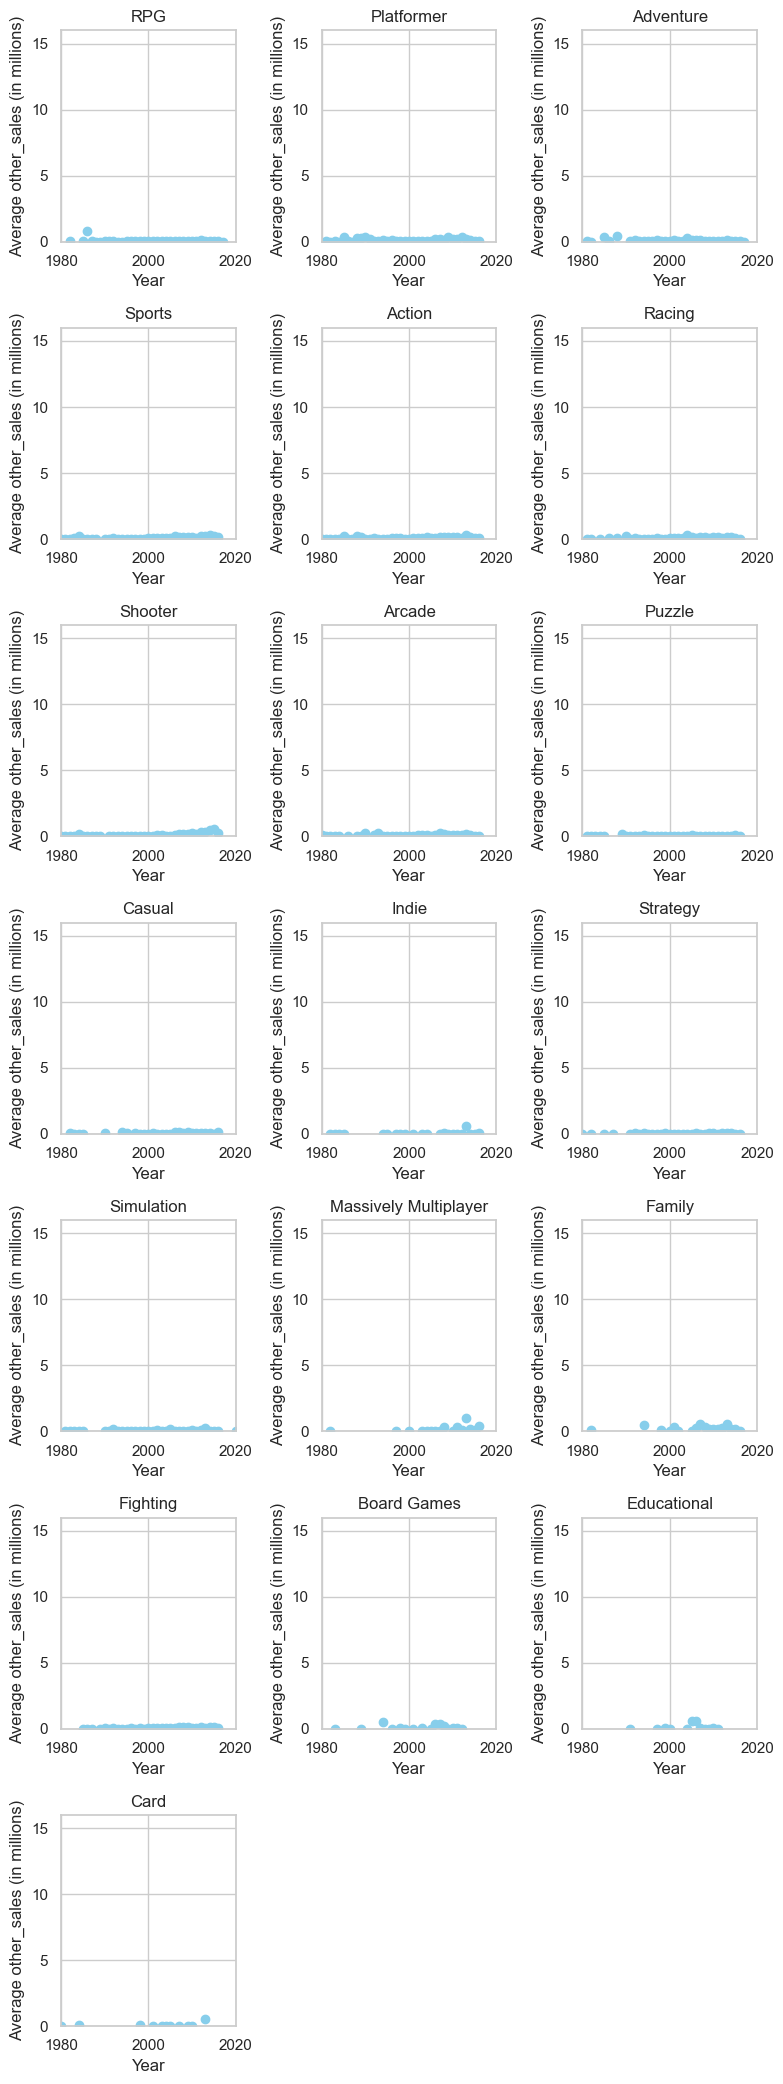

In [27]:
plot_mean_by_genre_per_year('other_sales')

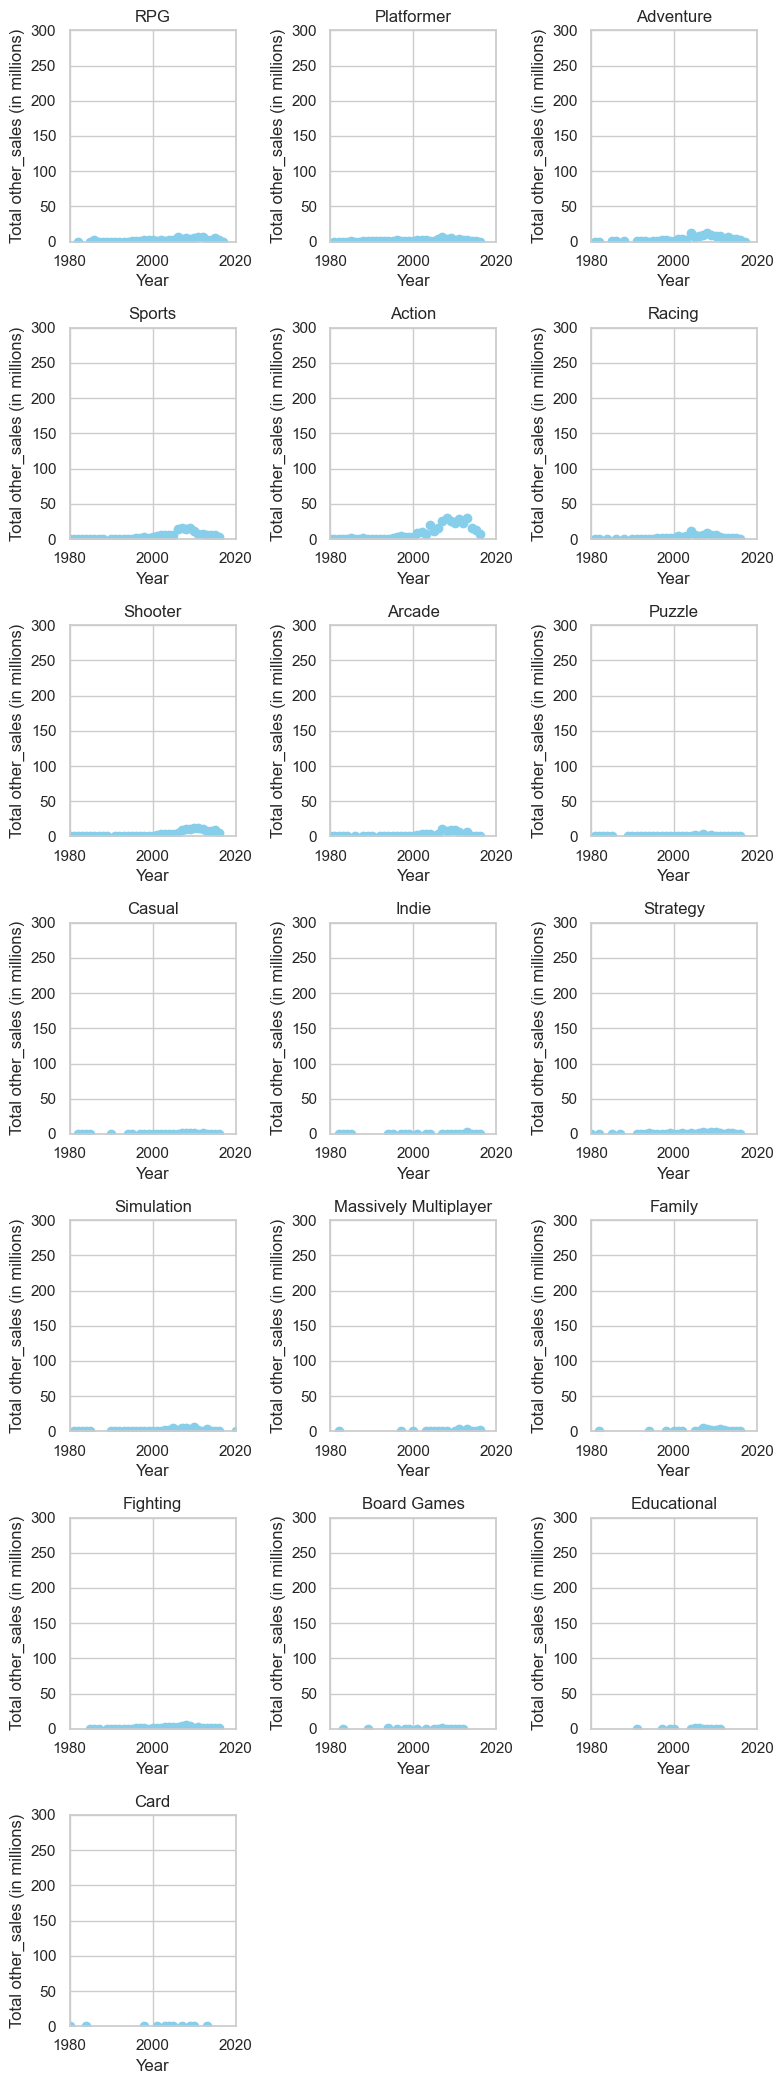

In [28]:
plot_total_by_genre_per_year('other_sales')

# Release timing analysis

We are using a different subset of the data in the time analysis, so we create a new dataframe. 

In [42]:
# Read the CSV files
df1 = pd.read_csv('game_info.csv')
df2 = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

# Standardizing the column names
df2.columns = df2.columns.str.lower()
df1.columns = df1.columns.str.lower()

# This will only keep rows where the 'name' is found in both dataframes
merged_df = pd.merge(df2, df1, on='name', how='left', suffixes=('_df2', '_df1'))
merged_df = merged_df.dropna(subset=['released'])

columns_to_drop=['year_of_release', 'genre', 'platform', 'publisher', 'critic_score',
       'critic_count', 'user_score', 'user_count', 'developer', 'rating_df2',
       'id', 'slug', 'metacritic', 'tba', 'updated', 'website',
       'rating_df1', 'rating_top', 'playtime', 'achievements_count',
       'ratings_count', 'suggestions_count', 'game_series_count',
       'reviews_count', 'platforms', 'developers', 'publishers', 'esrb_rating',
       'added_status_yet', 'added_status_owned', 'added_status_beaten',
       'added_status_toplay', 'added_status_dropped', 'added_status_playing', 'genres']
# Drop the redundant columns
result_df = merged_df.drop(columns=columns_to_drop)

result_df['released'] = pd.to_datetime(result_df['released'])
result_df['month_day'] = result_df['released'].dt.strftime('%m-%d')
result_df['month'] = result_df['released'].dt.month
result_df['day'] = result_df['released'].dt.day
result_df = result_df.sort_values(by='month_day')

# remove outlier
result_df = result_df[result_df['month_day'] != '01-01'] 
result_df

,name,na_sales,eu_sales,jp_sales,other_sales,global_sales,released,month_day,month,day
969,Virtua Fighter 4,0.78,0.44,0.56,0.04,1.81,2001-01-02,01-02,1,2
8022,Hidden Mysteries: Vampire Secrets,0.06,0.11,0.00,0.02,0.18,2013-01-02,01-02,1,2
14306,CT Special Forces,0.02,0.01,0.00,0.00,0.03,2001-01-02,01-02,1,2
1305,Super Monkey Ball,0.95,0.37,0.10,0.04,1.46,2001-01-02,01-02,1,2
2006,UFC Undisputed 3,0.55,0.32,0.03,0.13,1.03,2012-01-03,01-03,1,3
...,...,...,...,...,...,...,...,...,...,...
3435,Q*bert,0.55,0.03,0.00,0.01,0.58,1982-12-31,12-31,12,31
2074,NBA Live 97,0.55,0.38,0.00,0.07,1.00,1996-12-31,12-31,12,31
4652,The Suffering,0.20,0.16,0.00,0.05,0.42,2003-12-31,12-31,12,31
7200,The Suffering,0.16,0.05,0.00,0.01,0.22,2003-12-31,12-31,12,31


## All time analysis

C:\Users\henri\AppData\Local\Temp\ipykernel_6600\2586408061.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_sales['month'], y=monthly_sales['global_sales'], palette='viridis')


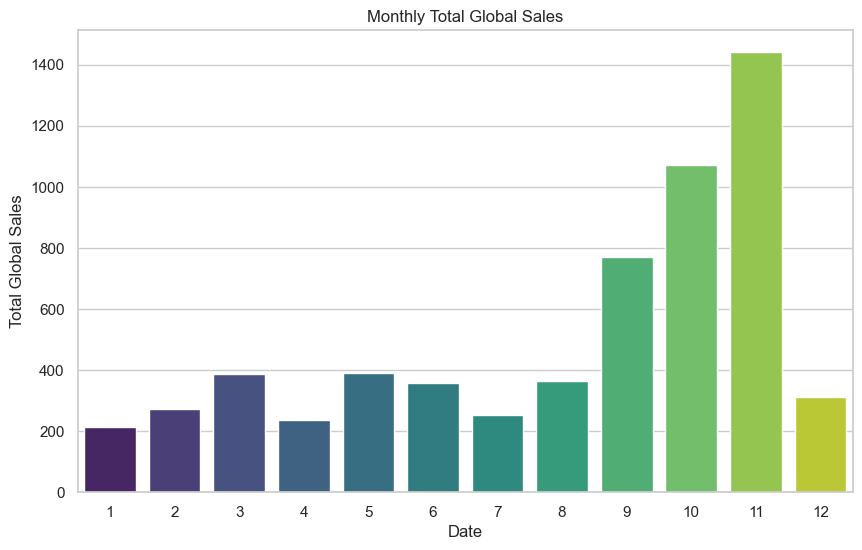

Day with the highest sales: 11-19


In [44]:
monthly_sales = result_df.groupby('month')['global_sales'].sum().reset_index()
daily_sales = result_df.groupby('month_day')['global_sales'].sum().reset_index()

# Plot the monthly global sales
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_sales['month'], y=monthly_sales['global_sales'], palette='viridis')
plt.title('Monthly Total Global Sales')
plt.xlabel('Date')
plt.ylabel('Total Global Sales')
#plt.savefig('Monthly total global sales.svg', dpi=600)
plt.show()
day_with_highest_sales = daily_sales.loc[daily_sales['global_sales'].idxmax()]
print(f'Day with the highest sales: {day_with_highest_sales.iloc[0]}')

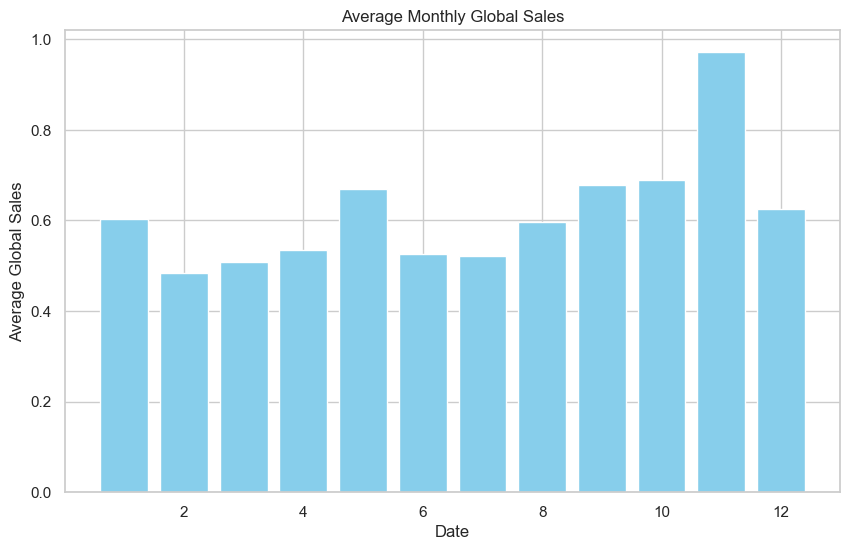

In [31]:
# Calculate average sales per month
average_sales = result_df.groupby(result_df['month'])['global_sales'].mean().reset_index()

# Plot the average monthly global sales
plt.figure(figsize=(10, 6))
plt.bar(average_sales['month'], average_sales['global_sales'], color='skyblue')
plt.title('Average Monthly Global Sales')
plt.xlabel('Date')
plt.ylabel('Average Global Sales')
plt.show()


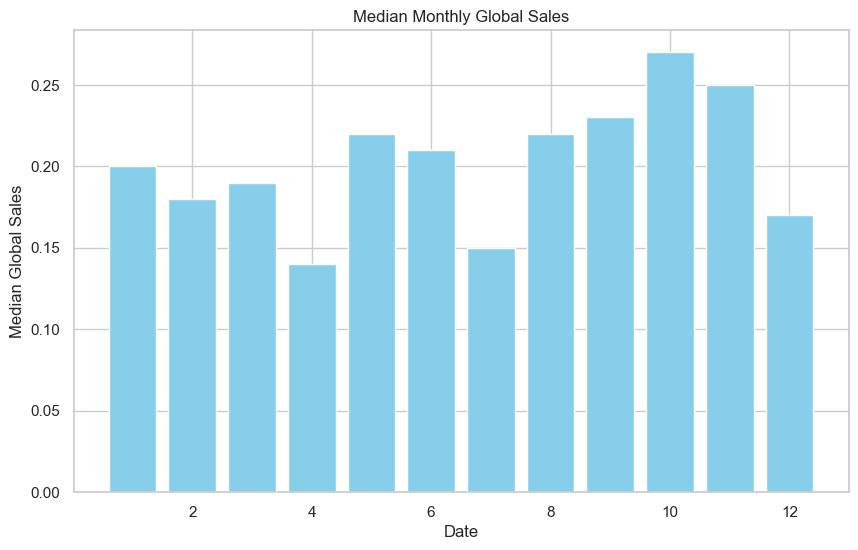

In [32]:
# Calculate average sales per month
average_sales = result_df.groupby(result_df['month'])['global_sales'].median().reset_index()

# Plot the average monthly global sales
plt.figure(figsize=(10, 6))
plt.bar(average_sales['month'], average_sales['global_sales'], color='skyblue')
plt.title('Median Monthly Global Sales')
plt.xlabel('Date')
plt.ylabel('Median Global Sales')
plt.show()


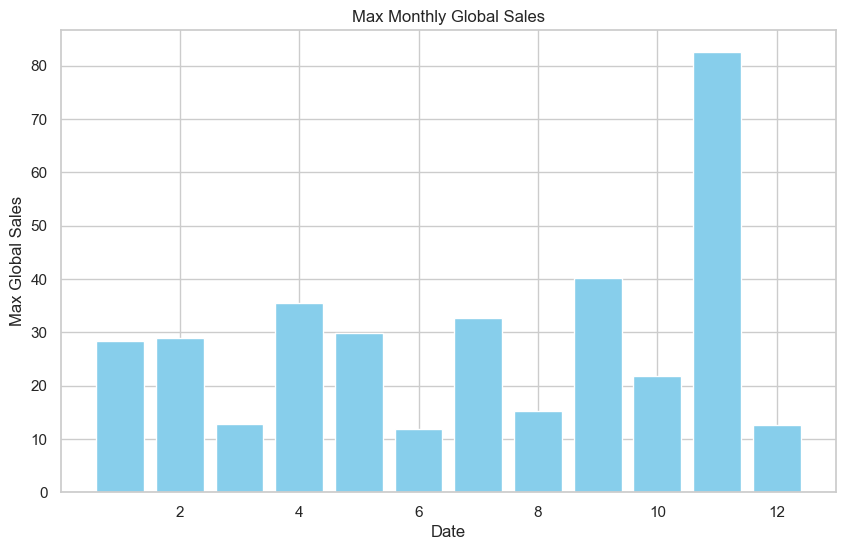

In [33]:
# Calculate average sales per month
average_sales = result_df.groupby(result_df['month'])['global_sales'].max().reset_index()

# Plot the average monthly global sales
plt.figure(figsize=(10, 6))
plt.bar(average_sales['month'], average_sales['global_sales'], color='skyblue')
plt.title('Max Monthly Global Sales')
plt.xlabel('Date')
plt.ylabel('Max Global Sales')
plt.show()

### Analysis by month (insignificant)

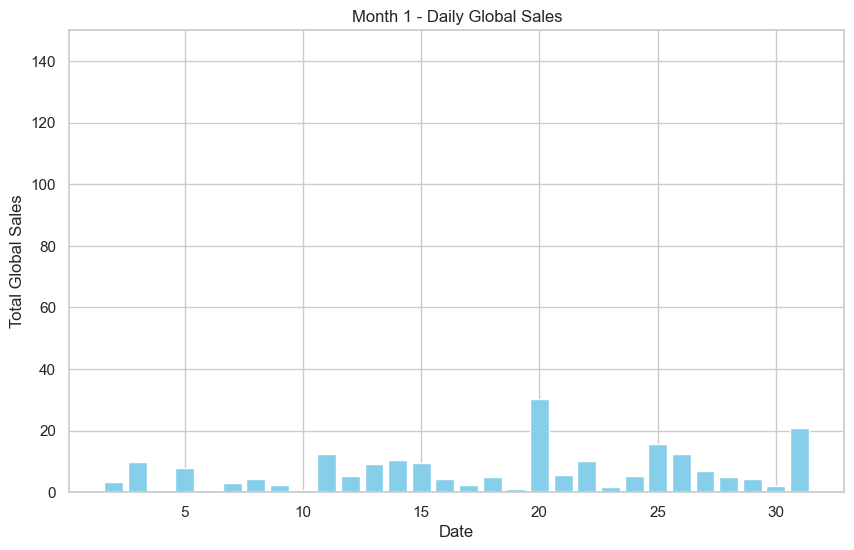

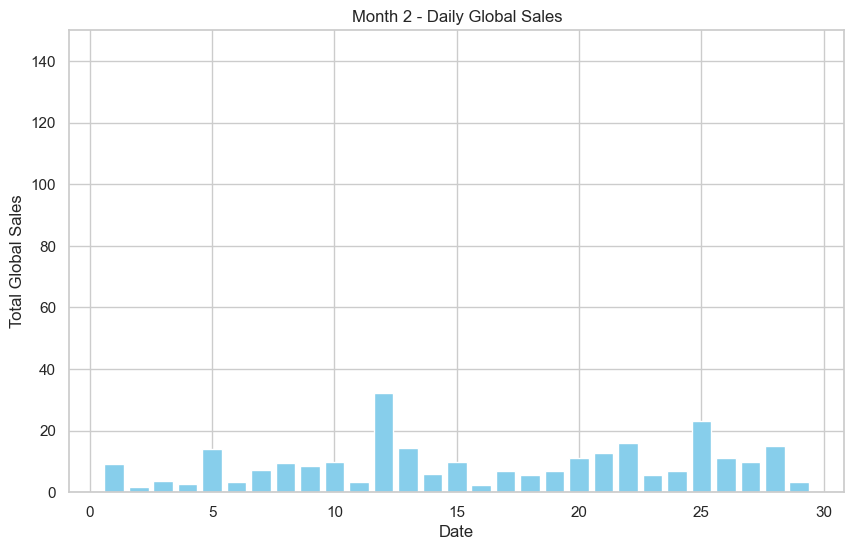

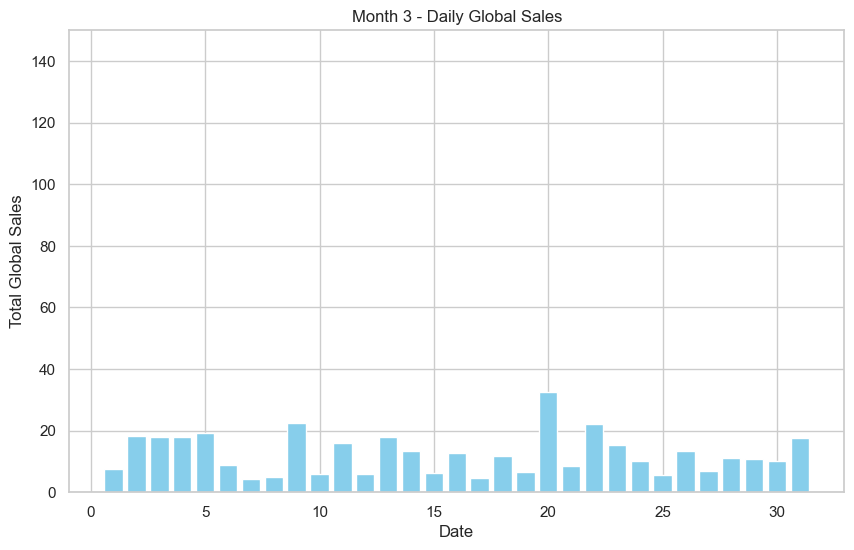

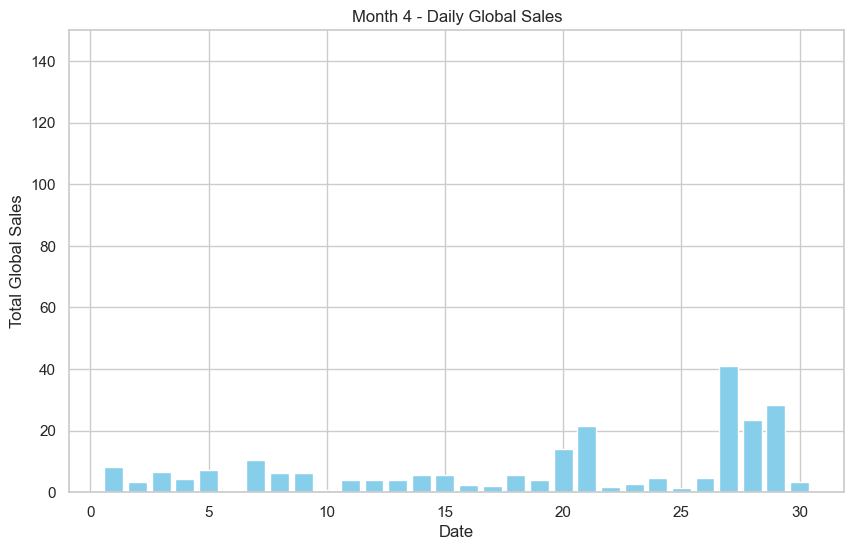

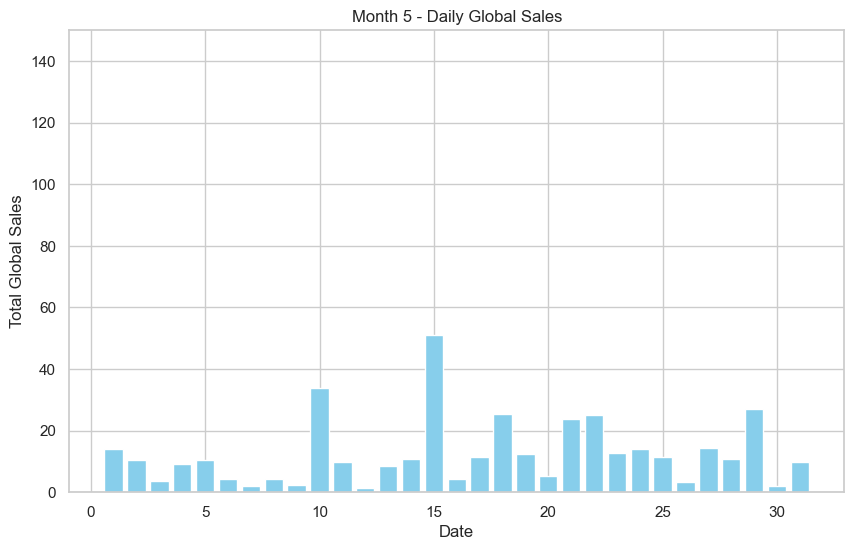

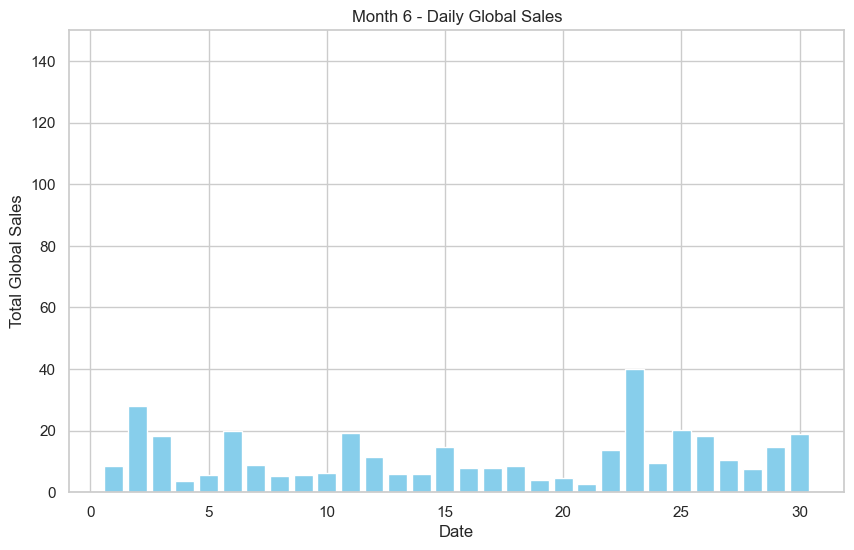

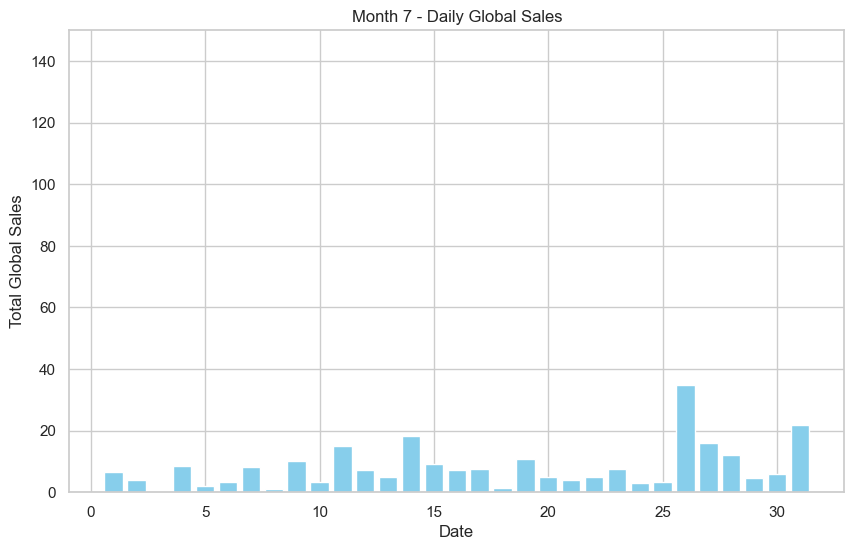

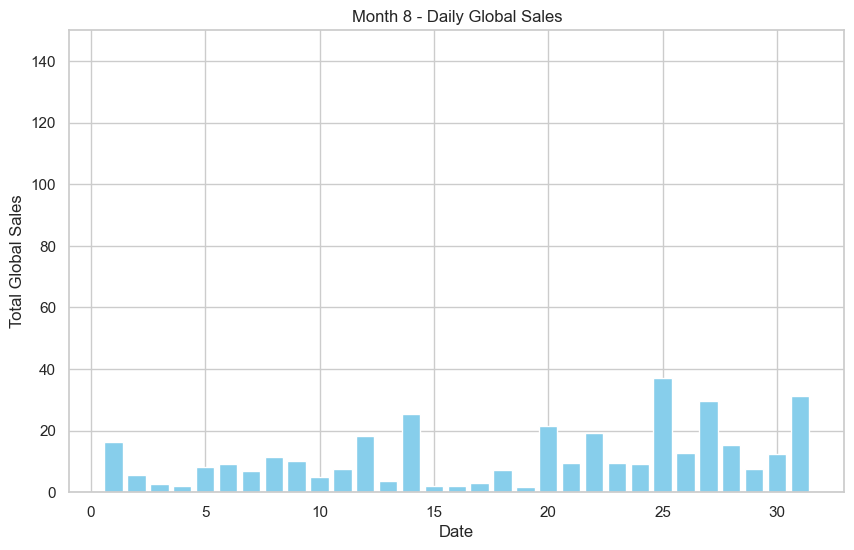

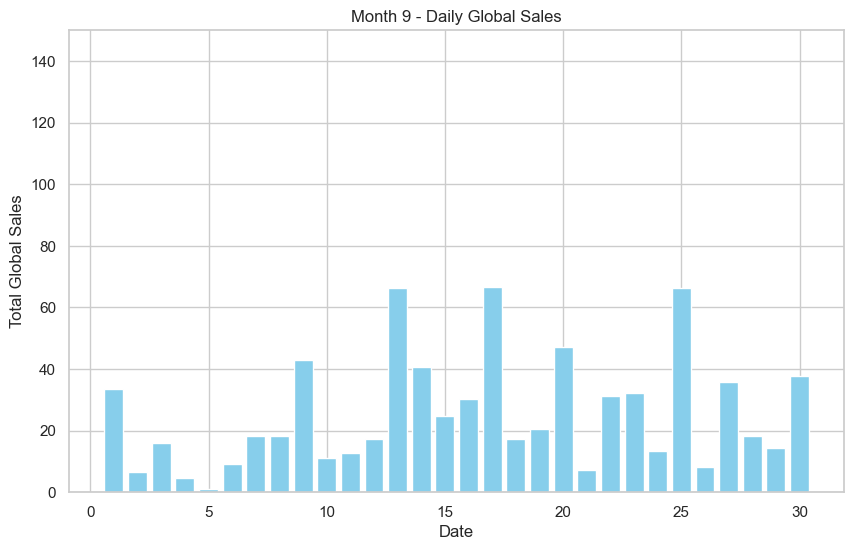

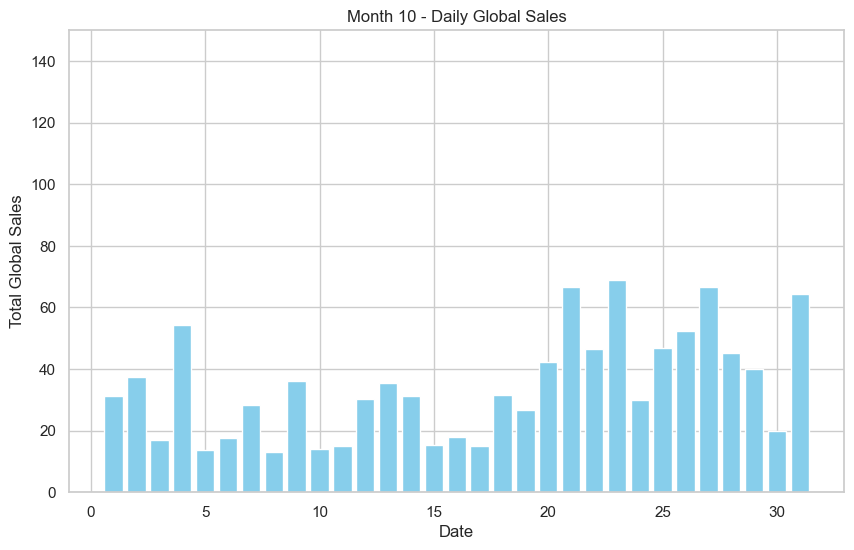

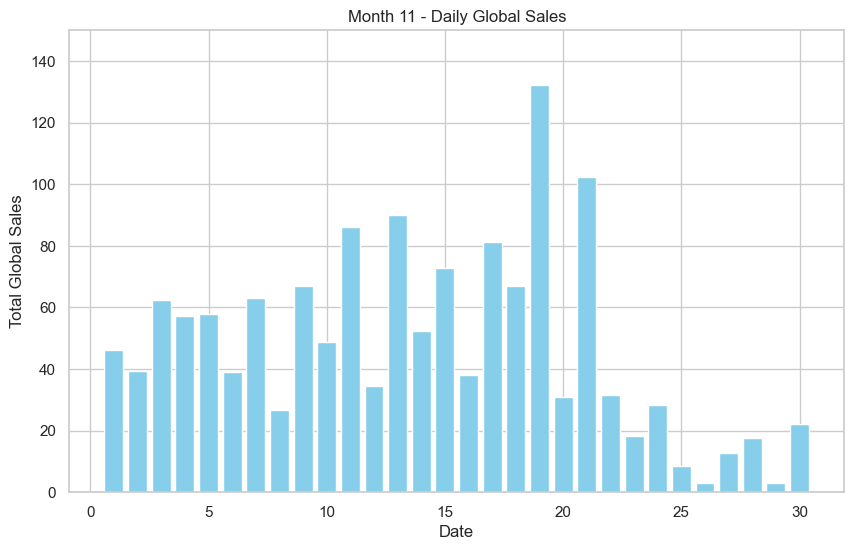

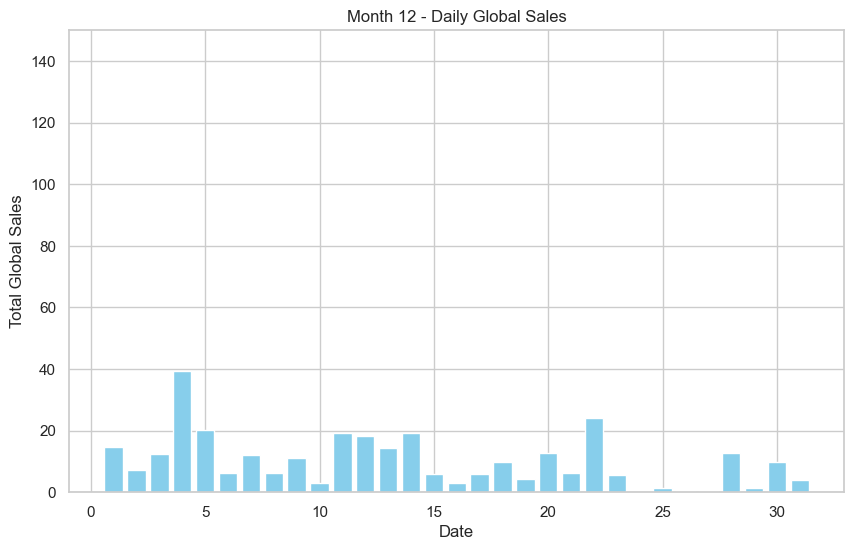

month_day        11-19
global_sales    132.25
Name: 322, dtype: object


In [34]:
daily = result_df.groupby('month_day')['global_sales'].sum().reset_index()

unique_months = result_df['month'].unique()

for month in unique_months:
    month_data = result_df[result_df['month'] == month]
    daily_sales = month_data.groupby('day')['global_sales'].sum().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(daily_sales['day'], daily_sales['global_sales'], color='skyblue')
    plt.title(f'Month {month} - Daily Global Sales')
    plt.xlabel('Date')
    plt.ylabel('Total Global Sales')
    plt.ylim(0, 150)
    
    plt.show()

day_with_highest_sales = daily.loc[daily['global_sales'].idxmax()]
print(day_with_highest_sales)

## Analysis by decade 

We analyse sales metrics by month every decade. 

Highest sales in 1980s: 09-13 - 40.24 million
Highest sales in 1990s: 11-21 - 20.61 million
Highest sales in 2000s: 11-19 - 82.53 million
Highest sales in 2010s: 01-20 - 28.31 million


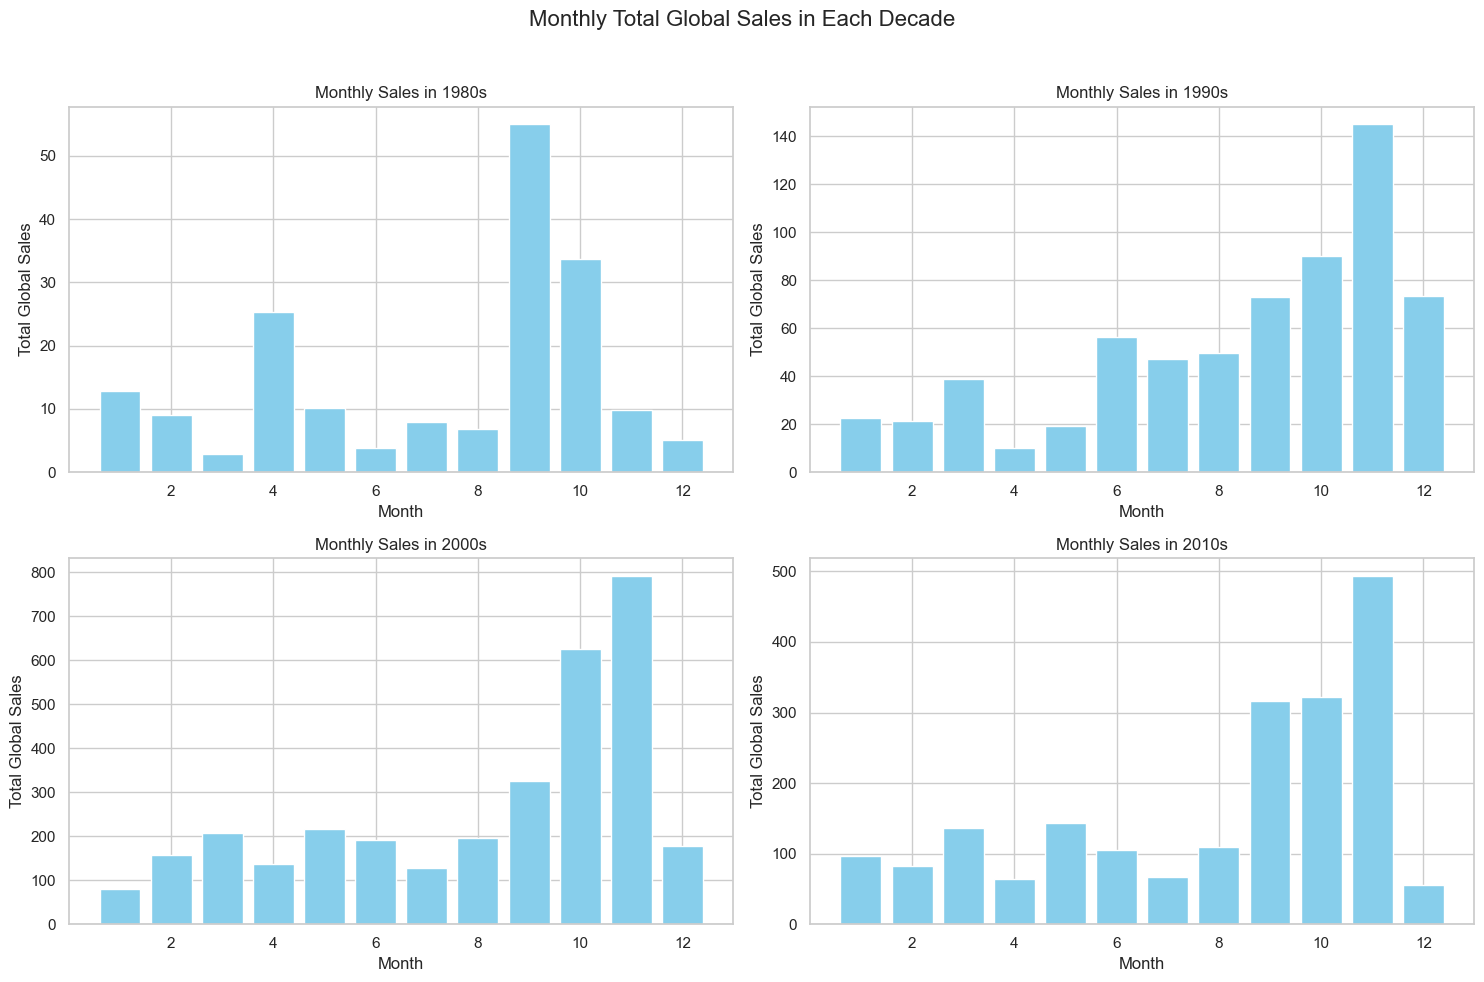

In [35]:
# Assuming 'result_df' is your DataFrame
result_df['decade'] = (result_df['released'].dt.year // 10) * 10

# Create subplots for each decade
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Monthly Total Global Sales in Each Decade', fontsize=16)

# Plot monthly global sales for each decade
for decade, ax in zip([1980, 1990, 2000, 2010], axes.flatten()):
    decade_df = result_df[result_df['decade'] == decade]
    
    monthly_sales = decade_df.groupby('month')['global_sales'].sum().reset_index()
    ax.bar(monthly_sales['month'], monthly_sales['global_sales'], color='skyblue')
    ax.set_title(f'Monthly Sales in {decade}s')
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Global Sales')
    
    # Print the date with the highest sales for each decade
    day_with_highest_sales = decade_df.loc[decade_df['global_sales'].idxmax()]
    print(f'Highest sales in {decade}s: {day_with_highest_sales["month_day"]} - {day_with_highest_sales["global_sales"]:.2f} million')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

People buy the most games september through november, which makes sense because of the Christmas shopping period. 

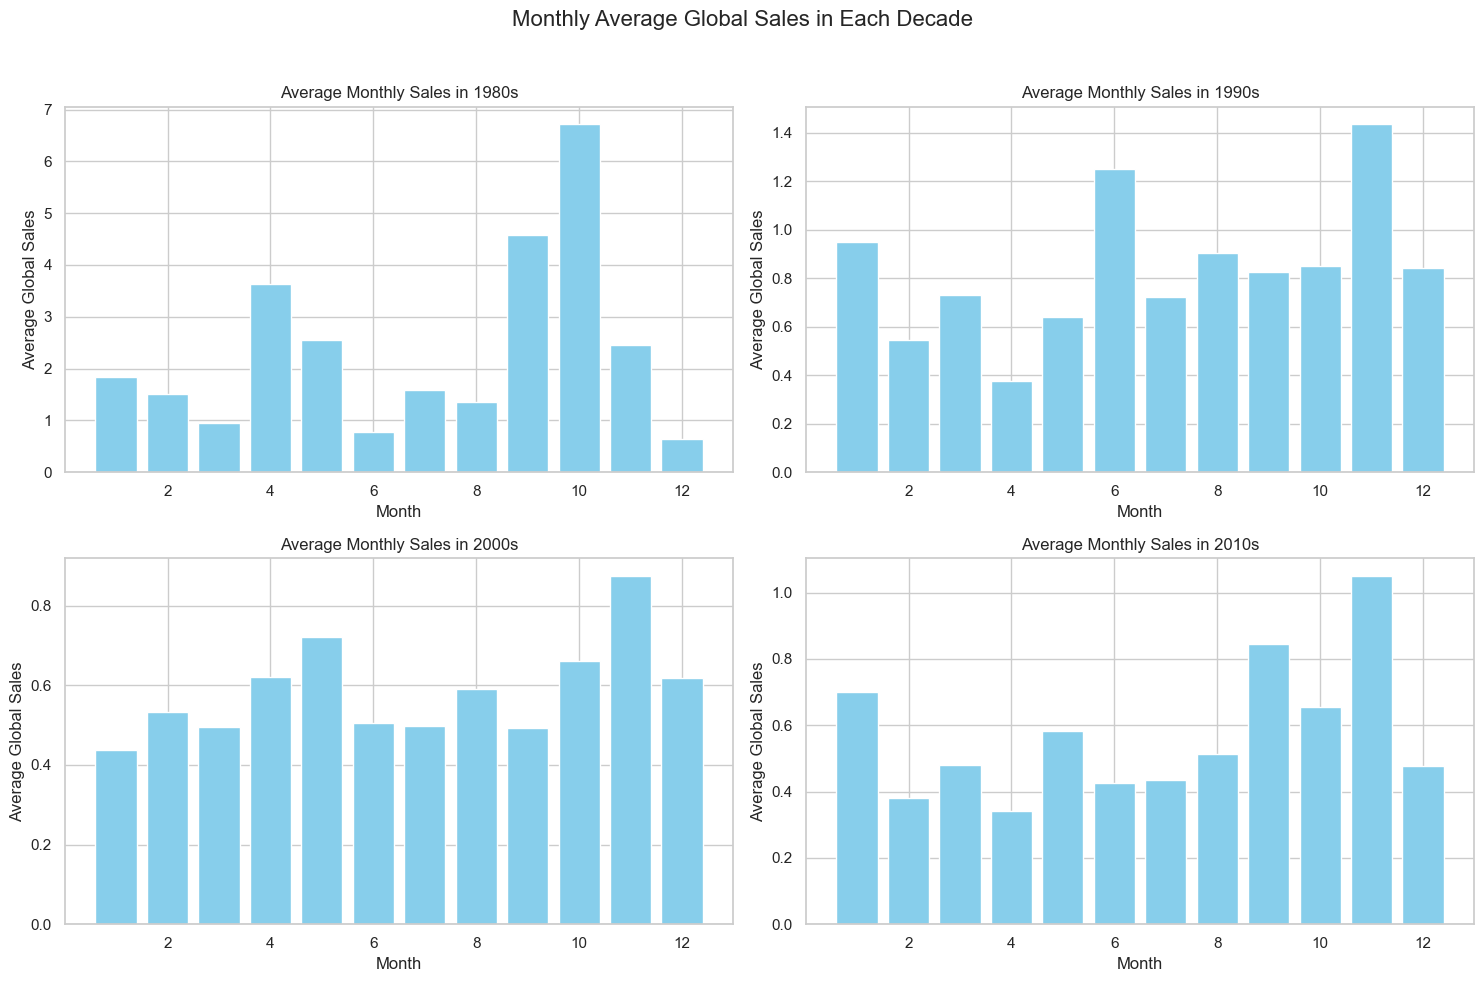

In [36]:
# Create subplots for each decade
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Monthly Average Global Sales in Each Decade', fontsize=16)

# Plot monthly global sales for each decade
for decade, ax in zip([1980, 1990, 2000, 2010], axes.flatten()):
    decade_df = result_df[result_df['decade'] == decade]
    
    monthly_sales = decade_df.groupby('month')['global_sales'].mean().reset_index()
    ax.bar(monthly_sales['month'], monthly_sales['global_sales'], color='skyblue')
    ax.set_title(f'Average Monthly Sales in {decade}s')
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Global Sales')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

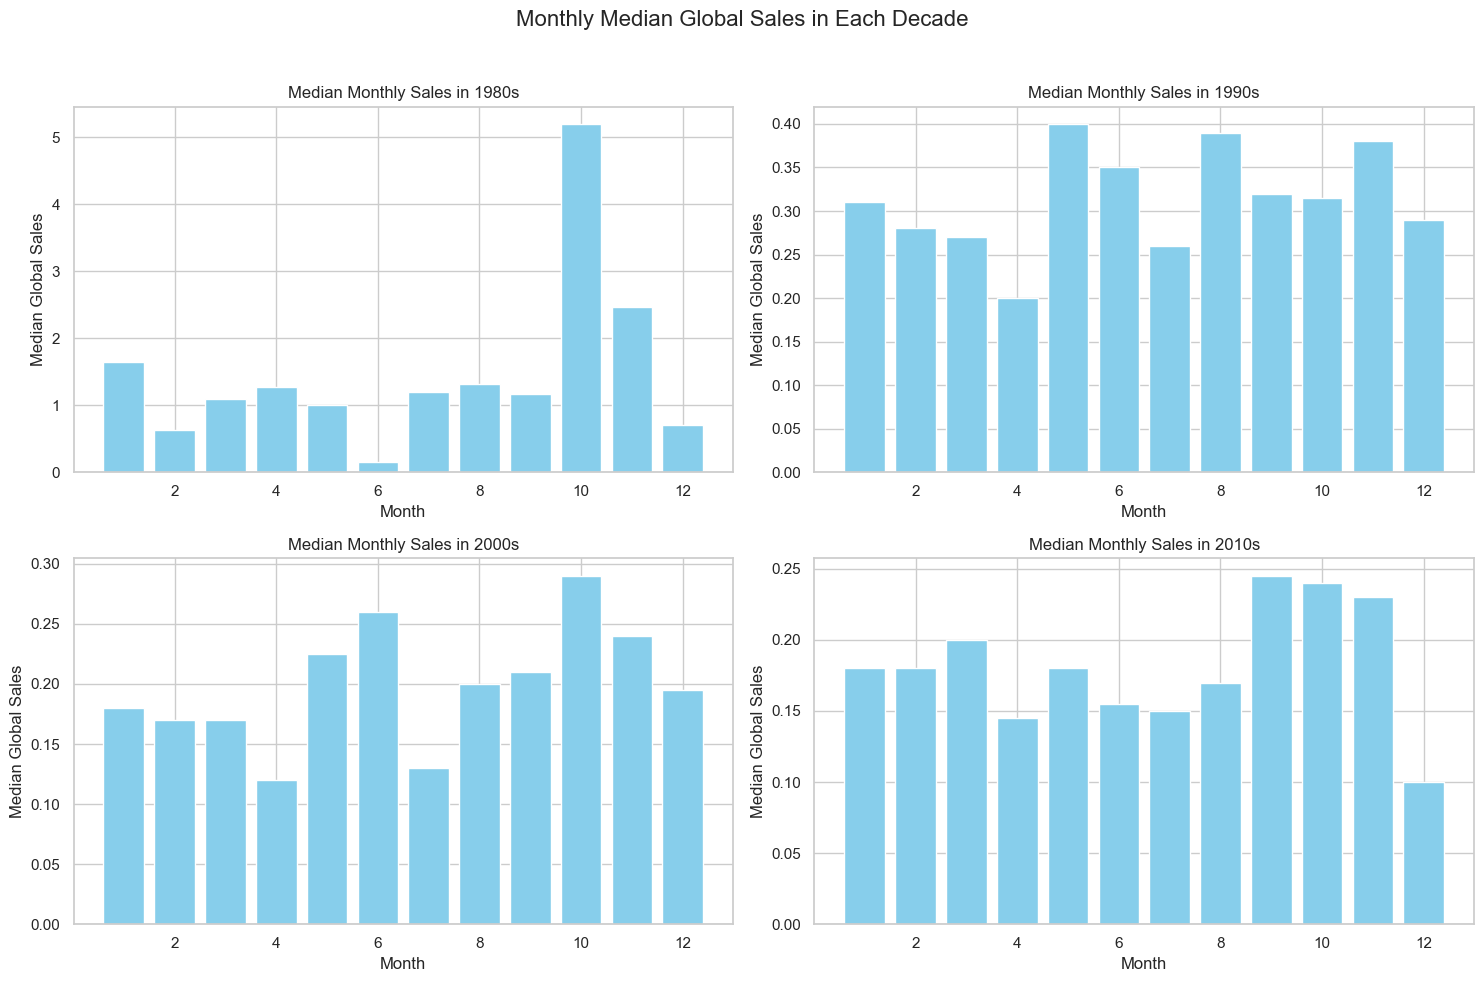

In [37]:
# Create subplots for each decade
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Monthly Median Global Sales in Each Decade', fontsize=16)

# Plot monthly global sales for each decade
for decade, ax in zip([1980, 1990, 2000, 2010], axes.flatten()):
    decade_df = result_df[result_df['decade'] == decade]
    
    monthly_sales = decade_df.groupby('month')['global_sales'].median().reset_index()
    ax.bar(monthly_sales['month'], monthly_sales['global_sales'], color='skyblue')
    ax.set_title(f'Median Monthly Sales in {decade}s')
    ax.set_xlabel('Month')
    ax.set_ylabel('Median Global Sales')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

When looking at averages and medians, the changes in months become more insignificant. 

From the release timing analysis, it appears that the optimal time to release a game is September through November.
